In [36]:
import csv
import numpy as np

# getting the train and test data from the csv file
test_x = np.loadtxt(open("../data/kaggle-music-genre/test.x.csv","rb"), 
                    dtype =np.float,
                    delimiter = ',',
                    skiprows=1, 
                    usecols=range(1,27))

train_x = np.loadtxt(open("../data/kaggle-music-genre/train.x.csv","rb"), 
                     dtype =np.float,
                     delimiter = ',',
                     skiprows=1, 
                     usecols=range(1,27))

In [37]:
test_x.shape, test_x.dtype, train_x.shape, train_x.dtype

((10400, 26), dtype('float64'), (13000, 26), dtype('float64'))

In [38]:
train_x[0]

array([  4.10800000e+01,   6.57900000e+00,   4.30700000e+00,
         3.42100000e+00,   3.19200000e+00,   2.07600000e+00,
         2.17900000e+00,   2.05200000e+00,   1.79400000e+00,
         1.97700000e+00,   1.97900000e+00,   1.85800000e+00,
         1.67100000e+00,  -1.34500000e+02,   1.71400000e+01,
         1.91900000e+00,   4.12100000e+00,   1.34700000e+00,
        -2.46300000e-01,  -1.54700000e+00,   1.79200000e-01,
        -1.15300000e+00,  -7.37000000e-01,   4.07500000e-01,
        -6.71900000e-01,  -5.14700000e-02])

In [39]:
# # Preprocessing: normalizing the data based on the training set
mean = train_x.mean(axis=0)
std = train_x.std(axis=0)
mean.shape, std.shape, mean.dtype, std.dtype

train_x = (train_x - mean)/ std

In [40]:
# getting the output data from the csv file
train_y = np.genfromtxt(open("../data/kaggle-music-genre/train.y.csv","rb"), 
                        dtype = 'str', 
                        delimiter=',',
                        skip_header=1, 
                        usecols=(1))
train_y.shape, train_y.dtype

((13000,), dtype('<U13'))

In [41]:
NB_TRAINING = train_x.shape[0]
desiredOutput = np.zeros(NB_TRAINING, dtype= int)

# initializing the output matrix for the training data
j = 0
outputtemp = train_y
while j < NB_TRAINING:
	str = outputtemp[j]
	if str == 'International':
		desiredOutput[j] = 4
	if str == 'Vocal':
		desiredOutput[j] = 1
	if str == 'Latin':
		desiredOutput[j] = 6
	if str == 'Blues':
		desiredOutput[j] = 0
	if str == 'Country':
		desiredOutput[j] = 1
	if str == 'Electronic':
		desiredOutput[j] = 2
	if str == 'Folk':
		desiredOutput[j] = 3
	if str == 'Jazz':
		desiredOutput[j] = 5
	if str == 'New_Age':
		desiredOutput[j] = 7
	if str == 'Pop_Rock':
		desiredOutput[j] = 8
	if str == 'Rap':
		desiredOutput[j] = 9
	if str == 'Reggae':
		desiredOutput[j] = 11
	if str == 'RnB':
		desiredOutput[j] = 10
	j = j+1

desiredOutput.astype(int)

desiredOutput.shape, desiredOutput.dtype

((13000,), dtype('int64'))

In [50]:
def forwardPass(X, w1, w2, b1, b2):
# in_nx26 @ w_26x13 + b_1x13 = o_nx13
	h = np.dot(X, w1) + b1 # X_nx26 @ w1_26xh = H_nxh
	h, cache = sigmoid_forward(h) # the same shape
	y = np.dot(h, w2) + b2 # h_nxH @ w2_Hx13 = y_nx13
	return y, h, cache

def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def sigmoid_forward(X):
    out = sigmoid(X)
    cache = out
    return out, cache

def sigmoid_backward(dout, cache):
    return cache * (1. - cache) * dout

# The model here is refering to the last layer model before softmax function applied.
def softmax(X):
    eX = np.exp((X.T - np.max(X, axis=1)).T)
    return (eX.T / eX.sum(axis=1)).T

def cross_entropy(y_pred, y_train):
    m = y_pred.shape[0]

    prob = softmax(y_pred)
    log_like = -np.log(prob[range(m), y_train]) # to avoid the division/dividing by zero
    data_loss = np.sum(log_like) / m

    return data_loss

def dcross_entropy(y_pred, y_train): # this is equal for both since the reg_loss (noise) derivative is ZERO.
    m = y_pred.shape[0]

    grad_y = softmax(y_pred)
    grad_y[range(m), y_train] -= 1.
    grad_y /= m

    return grad_y

def loss_function(y, y_train):

    loss = cross_entropy(y, y_train) # softmax is included
    dy = dcross_entropy(y, y_train) # dsoftmax is included

    return loss, dy

def backward_pass(dy, X, h, W2, cache):
    dW2 = np.dot(h.T, dy) # dW2_Hx13 = h_nxH.T @ dy_nx13
#     print(dy.shape)
    db2 = dy.sum(axis=0).reshape(1, -1)
    dh = np.dot(dy, W2.T) # dh_nxH = dy_nx13 @ W2_Hx13.T
    dh = sigmoid_backward(dh, cache) # the same
    dW1 = np.dot(X.T, dh) # dW1_26xH = X_nx26.T @ dh_nxH
    db1 = dh.sum(axis=0).reshape(1, -1)

    return dW1, dW2, db1, db2

In [54]:
# Hyperparameters
NB_FEATURES = 26
NB_CLASSES = 13
NB_HIDDEN = 64 # tweekable
LEARNING_RATE = 0.1 # tweekable
MINIBATCH_SIZE = 128 # tweekable

# initializing all the weigths randomly
w1 = 0.1 * np.random.randn(NB_FEATURES,NB_HIDDEN)
b1 = np.zeros((1, NB_HIDDEN))
w2 = 0.1 * np.random.randn(NB_HIDDEN,NB_CLASSES)
b2 = np.zeros((1, NB_CLASSES))

# Showing the lerning curve
train_loss = []

for epoch in range(100000):
    # Let's get the minibacthes randomly
	index = np.random.randint(0, 12999, size = MINIBATCH_SIZE)
	X_minibatch = train_x[index, :] # x_100x26
	Y_minibatch = desiredOutput[index] # y_100x1    
    
# We want the output of the weights, biases and input
	y, h, cache = forwardPass(w1=w1, w2=w2, X=X_minibatch, b1=b1, b2=b2)
    
# loss and dy for backward pass
	loss, dy = loss_function(y=y, y_train=Y_minibatch)
	train_loss.append(loss)   
	if (epoch//10000):
		print(loss)

# We 'll do the backward pass to get the w, b gradients
	dW1, dW2, db1, db2 = backward_pass(cache=cache, dy=dy, h=h, W2=w2, X=X_minibatch)

# 	# update the weights
	w1 += -LEARNING_RATE * dW1
	w2 += -LEARNING_RATE * dW2
	b1 += -LEARNING_RATE * db1
	b2 += -LEARNING_RATE * db2

2.40793642552
2.40369595273
2.3825023394
2.36085247293
2.37239451206
2.40563754014
2.34637119093
2.40792551067
2.33418892008
2.34115957012
2.34334684394
2.38080799502
2.36984233882
2.37927215305
2.37645710928
2.36331100421
2.36782198457
2.39041944761
2.3406523422
2.36880582427
2.37568105009
2.3782227523
2.38334018693
2.34640777464
2.42115354737
2.35189080206
2.35745664763
2.34169821393
2.36363249877
2.31364343563
2.33736070517
2.34947550717
2.35216346556
2.34906873002
2.33890014077
2.35539779614
2.34558293102
2.31970543868
2.31407934553
2.33007279024
2.32332024351
2.32665403107
2.30113202109
2.33743052545
2.38260364531
2.28198354161
2.3134415468
2.33580024209
2.30945181782
2.34654015521
2.35822289439
2.33862884704
2.31522510023
2.30181138295
2.30378034531
2.40100385414
2.31105552957
2.34015985346
2.31726726199
2.2671135419
2.31094570837
2.26613716706
2.29115349507
2.32723655088
2.28399768637
2.34039583456
2.31998540021
2.29399164424
2.31260385751
2.32072342325
2.33574524953
2.306333820

2.04265958078
2.01634445219
2.02230557877
2.10870382347
2.08953467478
1.97602439165
2.00749040274
1.90477140467
1.95481084671
1.96947025171
2.0024987557
1.96374276416
2.00412586904
2.00637603129
2.12279951778
1.92141637802
2.05030454463
1.93693046867
1.99845108019
1.95972326919
2.03859762499
2.13581543684
2.07181751047
1.92290623046
1.88123354644
2.05853093656
2.02582646429
1.97151468346
2.03530107501
1.97825608465
1.9670475613
2.02131640064
1.9346212998
2.01436224592
2.10051427525
1.83475564098
2.05968540805
1.92776268142
1.96876961731
1.99087622915
2.06074757032
1.9659087261
1.99733333433
2.08276106952
2.110614796
2.0883677143
1.94670111628
1.89239418479
2.02319439904
1.97070852507
1.89666196507
1.96294138004
1.98611553155
1.9265155831
2.01044295875
1.99829204039
1.9722087461
2.04337617565
2.00729441043
1.90331806816
1.93937911409
1.99020385669
2.07444507607
2.10400085015
2.02346343602
2.2000636069
2.00016514461
2.09418959626
1.95076210851
2.01798289027
2.00819378191
1.95013124974
2.

1.79674220634
1.96289075319
1.90270754856
1.98584470874
1.93413528384
1.8602731805
1.94062194343
1.94813767761
1.97375828155
1.92970641421
2.05161695017
1.95539634477
1.87270965677
1.83032931301
1.96099435433
1.74030510566
1.82836849422
1.93059916561
1.80841884235
1.95221764933
1.98573141999
2.02285105448
2.05858065771
2.00440831215
1.83277384831
1.87027558578
2.00473846443
1.92026449768
1.9557519685
1.87622274931
1.92390422671
2.15519642076
1.80069239673
1.89613625175
1.92521026817
1.92236344731
2.01262294836
1.90962118571
1.82331774449
1.88809442984
1.93965473317
1.96937033762
1.9821265548
1.98264262307
2.00046325547
1.75130795259
1.97436356075
1.89609268058
1.93273896391
2.11806537327
1.96573573349
1.91638929969
2.00145645181
2.12036428631
1.88872349104
1.99739320934
1.99396796351
1.89740946468
1.83059267779
1.80865696274
1.97227538288
1.81904504895
2.08300977025
1.9243140407
1.98436000557
2.04342960973
1.99313875676
1.99587471355
1.89259049474
1.91185926123
2.08565042105
1.94575692

1.73710689415
1.88381514324
1.89645217704
1.83400015382
1.86675785784
1.87993582955
1.84559488068
1.7680209199
1.7925498664
1.97273544234
2.03865117841
1.88633956771
2.00006900554
1.85224875867
2.06031291088
1.8783509888
1.87354645458
1.98537828585
1.83819009162
1.85087646525
1.98846934536
1.97170638275
1.99367944665
1.83804471905
1.82315971894
1.85081090553
1.80654057948
1.77376445551
1.82153060821
1.79009029815
2.04105104298
1.90730622161
1.87803307331
1.8400381937
1.81851200758
2.05521101043
1.73922954943
2.01131713582
2.01759017662
1.89440171919
1.8773833642
1.87997436215
1.77132160489
1.99414540376
1.91218383791
1.89687685419
1.79710005236
1.91090640683
1.78608419575
1.9122331153
2.00445051999
1.90850220288
1.92846475996
1.96616657677
1.90295367048
1.86030869731
1.9638396643
1.76635548823
1.91934418756
2.01553246521
1.93976766997
1.81675169964
1.85667422876
1.99437744363
1.92805055627
1.81449003357
1.87921456285
1.88020634108
1.88408297592
2.04282665672
1.89761432507
1.80694506431

1.86519973724
1.81886082869
2.05619643525
1.78418246061
1.84362531484
1.7283866903
1.9080382198
1.77842427621
1.73246523009
2.0756453772
1.91389650471
1.89425646602
1.93139956129
1.84675857409
2.03640108742
1.99405072793
1.9111012094
1.89590591209
1.85487723055
1.77213188596
1.83952400839
1.918353523
1.8425283352
1.92243843965
1.7688777305
2.01375672298
1.94585478716
1.88728867825
1.98923402018
1.89607192707
1.81530776225
1.81654420687
1.7702185827
2.04482321786
1.95772885633
1.93198195439
2.12920286465
1.84465465082
1.89681367224
1.72407188331
1.95819299539
1.9942333805
1.78095788943
1.848925804
1.92916573424
1.93303702566
1.92233456238
1.87073506474
1.95500518818
2.02623568473
1.9074492252
1.71436399848
2.06348786004
2.01199664517
1.96761155399
1.81235230184
1.9313958693
1.99279112858
1.78957817287
1.78503589426
1.86117395905
1.87162352121
1.93232528773
1.94753711195
1.8601403392
1.80335907993
1.9095425229
1.93368620885
1.84745981496
1.89380160026
1.77413135981
1.894121718
1.95522944

1.79707480123
2.14210159861
1.81850264531
1.79978514902
1.94258502041
1.93724790003
1.86062284638
1.79592545016
1.96437292171
1.79488055714
1.92778287323
1.94347094837
1.91593833254
1.79924722155
1.9649985136
1.84666352539
1.86818939936
1.87004310333
1.79593245195
1.83549660282
1.70770998803
2.00667248457
1.76258445479
1.81139187359
1.75310132611
1.82879238383
1.71771988368
1.80473204619
1.96361156356
1.76736323398
2.01097322019
1.80751065244
1.80632680434
1.91534418246
1.83286739636
1.84874415405
1.79259007855
1.76647107809
2.02333612007
1.99270847014
1.98563776523
1.84509371011
1.77789823899
2.0348005996
1.93481245004
2.05866424922
2.04951535139
1.88460617115
1.91083523581
1.9819585161
1.95756655559
1.96740828972
1.94776126069
1.86596861656
1.85225816315
1.97892856827
1.87760226001
1.99784719533
1.8941066965
2.066011956
1.90329162645
2.00080700037
1.90502737285
1.70328214101
1.92919444249
1.68802714494
1.75454023714
1.88801898173
1.92631998449
1.97078424048
1.77059944764
1.8492617033

1.78868560408
1.98056389446
2.01698318369
1.82265061045
1.90374644075
1.82727501902
1.85278646803
1.81149941433
1.73307188191
1.85888289704
1.85735242057
1.78982214264
1.84568773833
2.01415895111
1.81059767533
1.94593664755
1.93484745806
2.10405994857
1.75495720893
1.87903922567
1.7601241731
1.74358309942
1.95189061539
1.84042018058
1.85276258128
1.88704832097
1.67676688359
1.67276522486
1.81238146757
1.87382573042
1.94480094213
1.89260650662
1.98294813288
1.8118900819
1.74609449931
1.87812203733
1.89742908571
1.84572384637
1.90450795835
1.94392248765
1.93402109413
1.87213746174
1.85110105495
1.78445857755
1.92283284661
1.80600872429
1.79657105951
1.87059450749
1.89988724062
1.96933914767
2.08352238595
1.85697161245
2.13099611227
1.8005823437
1.90116673131
1.85370978335
1.96912724676
1.90427607444
1.99875253592
1.7332589083
1.89128131478
1.87781859822
1.85303850367
1.91561755331
1.94372620783
1.80367114947
1.95249592973
1.87064408371
1.89555005093
1.84570082199
1.84833798063
1.89497662

1.94472133107
1.78011704747
1.86378315751
1.97602035995
2.10037143366
1.80845537345
1.79922667667
1.89686358438
1.91739951995
1.70751322984
1.99333538037
1.75991198733
1.84203789831
1.89172098062
1.82393492914
1.89004943995
1.7633480721
1.68584529815
1.89808598598
1.95741775663
1.83475115617
1.92033254237
1.76882446474
1.98660902867
2.01940249013
1.82660497728
1.97604593056
1.95500113789
1.85350126985
1.9970404082
1.71673590131
1.84671235776
1.94765117349
1.8260751517
1.84499602737
1.97516444354
2.03160736667
1.80211833202
1.85965271302
1.92435275714
1.99544580635
1.92268410579
1.96509098123
1.87091373847
1.85948386458
1.71762926533
1.74385982287
1.8714168206
1.78232501008
2.00945268812
1.90949764105
1.87604411964
1.82779070827
1.93500712641
1.89902672267
1.93072391133
1.75278816758
1.81015682353
1.92705905101
1.90437111285
1.8247911257
1.86826662377
1.72968308442
1.78994051202
1.84291709943
1.81293878677
1.93623997525
1.82486209997
1.88970259291
1.74116171933
1.83387043794
1.640311168

2.03296816618
1.93057434016
1.81893119722
1.70122592227
1.90761355125
1.8418702902
1.80519419905
1.89260855272
1.81893269404
1.88597542645
1.82500345588
1.77002468627
1.94428639238
1.95181562394
1.97159389211
1.87759780445
1.86835532242
1.81762386261
1.80915626964
1.92528600985
1.92534884694
1.80295709544
1.98633864989
1.69476070603
1.798247815
1.93981460866
1.84388443117
1.74685337764
1.98004013128
1.9048179464
1.98906714815
1.82008772353
1.93975301925
1.9434653416
1.81018302552
1.8092091486
1.7303857401
1.80230535686
1.83424207452
1.90844366762
1.69468777409
1.78849210912
2.05088567993
1.71215353687
1.93139177429
1.7785478519
1.71136699309
1.82779143844
2.00901517908
1.88263810639
1.91245413322
1.87448054003
1.88687449192
1.94100702923
1.81817242975
1.84887551636
1.84666006237
1.87309552857
1.72889025838
1.85029308481
1.85193579878
1.90325597207
1.7526558161
1.87117503018
1.85131219214
2.00273350099
1.83870472859
1.90060934893
1.67082616186
1.94426158076
1.82911592183
1.80607500436
1

1.87407720542
1.85091605783
2.0171431219
1.74160434855
1.90547190997
1.68543661739
1.95956456635
1.86353201112
1.95155303531
1.85463254411
1.84716381865
1.85267959811
1.94636750208
1.772230716
1.75822276729
1.85946356521
1.8456980495
1.76084494095
1.85417669664
1.76052866901
1.74251948852
1.83790506391
1.95919225958
1.92106483204
1.86680487672
1.7740645348
1.74352954378
1.8476527094
1.67453810129
1.89311001692
1.78597734762
1.85370855322
1.82356330589
1.80371160124
1.67790011623
1.88966388944
1.83516693692
1.80496057091
1.81297902101
1.89870818271
1.75211909123
1.84568582425
1.88862086762
1.90094135815
1.70172572417
1.8826767043
1.79895748455
1.9943487989
1.84226051377
1.78831261546
1.64631833835
1.95476297872
1.96697515809
1.99361069873
1.70207855607
1.96089346875
1.85313703783
1.88775692476
1.94556033135
1.75234695094
1.78007380043
1.71988638413
1.80120469292
1.85188872187
1.98292732332
2.01331492659
1.68721560426
1.80560954901
1.72964552467
1.95595005798
1.79262534848
1.87901399087


1.86447486752
1.89329894803
1.83719826689
1.75822431401
1.73570955305
1.85871482208
1.7519910033
1.87932882168
1.81898904563
1.69161122567
1.98097076442
1.92240632222
1.89861996759
1.80431530772
1.80033787242
1.91718063187
1.73748657532
1.78926356319
1.81131827928
1.78281494489
1.79533406978
1.86440476122
1.82930858695
1.92384215766
1.76638654824
1.78965521969
1.87264977404
1.74296735235
1.90723904519
1.8775736069
1.87901416904
1.92007228177
1.78810345496
1.86096618658
1.85499583376
1.67788676639
1.86724615823
1.60399964775
1.82110444974
1.95031416664
2.0489313704
1.96551180057
1.81037890369
1.86772494287
1.74133257961
1.93141550532
1.79022081208
1.97097356401
1.85917293469
1.75675272227
1.94032055721
1.85681480421
1.79241530531
1.74140255847
1.66866373313
1.84385438445
1.81828958632
1.72501123057
2.12879472185
1.90319906272
1.86381749451
1.83186555942
1.8768266265
1.83171211222
1.8026406536
1.7418399098
1.78560791576
1.6749443024
1.76210688673
1.78414853931
1.67793030967
1.9337910812


1.67596084123
1.74018187225
1.85695773532
1.87178251342
1.9741036014
1.85016428463
1.83743348519
1.74584092813
1.74981057684
1.67377061151
1.79959809672
1.92343022492
1.88130369967
2.00833015252
1.771335049
1.79785054115
1.86872609811
1.80021114131
1.85629474598
1.7132691538
1.75657774265
1.66413857401
1.74762117391
1.86398099554
1.69765598499
1.76652304131
1.88956446981
1.84142242704
1.78874442129
1.86263452404
1.67193361752
1.95730627885
1.72727943216
1.76396422418
1.79722387947
1.79445309819
1.8634992068
1.85980160768
1.70980812271
1.89695004278
1.7141323477
1.87411616382
1.77355749203
2.05605822197
1.7231237029
1.94014121695
1.9582231629
1.92905526782
1.75765205577
2.14474265035
1.95083186159
1.96053617324
1.84739084633
1.73942997867
1.91068946557
1.76324821379
1.75297555727
1.77604919219
1.94611854324
1.69573189399
1.85531299268
1.87237257059
1.7953427752
1.82057516083
1.93358627244
1.72682026796
1.86929049958
1.83784623303
1.91417801803
1.68501350392
1.80642893772
1.88732004129
1

1.7270502128
1.87154242115
1.9559508953
1.81329717675
1.89094912415
1.80815465548
1.83620724729
1.82332301745
1.78556821322
1.99108616252
1.67588443718
1.91154324688
1.86404366632
1.60186777927
1.80338285521
1.78814347289
1.86987991949
1.84890781326
1.9650336396
1.82308828525
1.84621735823
1.9047642814
1.96907570474
1.82196147094
1.70014918429
1.88380731596
1.7435415544
1.79857008234
1.77598095139
1.78762965971
1.73110525712
1.71284503024
1.73867070138
1.56317656355
1.72604470706
1.88152816722
1.82338155393
1.71649979551
1.78126286248
1.74393901001
1.99785552682
1.93142516594
1.84953727669
1.80920233909
1.79354876525
1.89581539279
1.77025866025
1.79706220929
1.76286599174
1.79648494119
1.82721107765
1.71195802141
1.95653053292
1.8881045824
1.76942756066
1.66290720336
1.82631321822
1.88071359248
1.66789564438
1.90433402017
1.79450932069
1.88070123977
1.83315971593
1.90625415437
1.83021303399
1.84464413459
1.99158692062
1.82605473426
1.71681575177
1.94816661932
1.83575425194
1.7818180288

1.78917559795
1.83172213888
1.86242669446
1.79794350426
1.81764493442
1.79800613107
1.88332992058
1.84171054821
1.86804043721
1.8380401452
1.71304214115
1.78481347975
1.7124891647
1.74014445725
1.72639309383
1.92873101696
1.93215286809
1.74311208564
1.8236337047
1.78489601479
1.96162351267
1.85579006363
2.0219820185
1.78414904855
1.80956747356
1.8437667987
1.89838824978
1.64706089846
1.83408150583
1.74565570492
1.70721357689
1.75935690577
1.84443889766
1.72385676687
1.8543861946
1.88262539443
1.77215960835
1.84947605844
1.75543383205
1.82487963625
1.71376197627
1.82337471763
1.87593908173
1.75604619426
1.75498754186
1.92081859195
1.86172307814
1.86818484418
1.82274145084
1.81713396565
1.77948584912
1.90019777811
1.87346273811
1.91581531216
1.79607401466
1.98020917141
1.79480471762
1.79977956492
1.76593902734
1.89227500838
1.79019461695
1.93055226678
1.76915626895
1.91710296321
1.95294622931
1.86644636417
1.63624182917
1.91663776266
1.65932120933
1.76318047016
1.77294549115
1.8654934686

1.72038306059
1.79785890321
1.84314993043
1.77008143633
1.79986348196
1.83347673012
1.84858312239
1.8139991571
1.89723701198
1.72942824255
1.74312353288
1.80302678403
1.8484520723
1.89316762726
1.76343784082
1.80292901195
1.84606288063
1.81577103912
1.85997951434
2.025675925
1.93541589361
1.7214629492
1.80537669434
1.87019942447
1.71649751259
1.7435129129
1.75618912484
1.79468506036
1.87963800595
1.8578188045
1.75323135033
1.78296300162
1.78670935545
1.84097742493
1.83078659772
1.81675793669
1.7821105098
1.79383186948
1.84194956758
1.80502062068
1.86522814928
1.76481459767
1.83763262334
1.81100548142
1.60342173378
1.76272891112
1.72980995376
1.70106292242
1.87290692764
1.7562259912
1.88072522616
1.7560422395
1.79002243422
1.85175018738
1.92542183863
1.98533003477
1.81306349545
1.69811279445
1.81722220125
1.75968962004
1.76144279646
1.7402881244
1.71244758364
1.72761083473
1.8296835787
1.77190371384
1.9419698487
1.77519160994
1.78343376422
1.75580807133
1.84954978644
1.78632705085
1.870

1.68945322254
1.87237473995
1.75218183333
1.875061087
1.72671161538
1.8772604287
1.77792271137
2.12563505132
1.9055565707
1.78794296666
1.80534359997
2.00773737498
1.93586197083
1.72008471245
1.70351728472
1.6669665305
1.94669530069
1.90638885897
1.72057595594
1.87546582235
2.02550263852
1.84982691661
1.86366965765
1.89347948763
1.80723623382
1.79998233971
1.65519971399
1.77484104056
1.92989683824
1.92743818638
1.73434912549
1.87131807102
1.79104261835
1.80186326365
1.82699624067
1.81177607255
1.77238422746
1.70393063387
1.6598529035
1.86302045992
1.83113696797
1.71395204827
1.70009117236
1.82036440251
1.77417270537
1.73570297703
1.71718835959
1.87215850578
1.87550802139
1.69519076891
1.79089223297
1.78408153687
1.84234144106
1.72217751337
1.67270100759
1.7825552796
1.7237056762
1.87118601436
1.93370256704
1.8321227445
1.89511155683
1.88469522929
1.76256865828
1.83169735284
1.84854182712
1.71496284847
1.81621629434
1.66326269245
1.89930419344
1.7312252013
1.91674130663
1.92688213548
1.

1.8670859562
1.98349641478
1.76189176656
1.93194399435
1.77927787924
1.81590448961
1.63557651976
1.95937196396
1.69677643678
1.8186729859
1.88651550357
1.89546623585
1.86732170189
1.8189436984
1.85528188628
1.83999829791
1.65567825244
1.79785933791
1.85904005286
1.82030947174
1.77463499259
1.71601184878
1.85438335954
1.98517116874
1.79028276374
1.72796067
2.00674101419
1.83533244429
1.83380619661
1.91306187732
1.90015382993
1.82358974863
1.82579995651
1.87260963987
1.82732073998
1.85662167233
1.83762312935
1.82462192744
1.81761184386
1.87210456
1.74747168127
1.80303814252
1.86898060474
1.86583166762
1.78992044563
1.88441370851
1.84750056209
1.62826243372
1.69315679977
1.62443924476
1.94224943129
1.87334866174
1.76340793506
1.99280377544
1.80271970159
1.72478584856
1.77591767674
1.88826850293
1.88859832224
1.92690666798
1.7723037778
1.85100504674
1.92578798547
1.71128483107
1.59373589074
1.80875889796
1.6646759196
1.85492617894
1.86491512741
1.9742942995
1.88522459824
1.82832382366
1.78

1.77055890161
1.79725256348
1.86467832571
1.93294236812
1.77648362187
1.89112346022
1.83964350703
1.87001023374
1.79439269709
1.82548235715
1.75231603349
1.96817801315
1.82301931434
1.89990358539
1.84547836059
2.02636369435
1.72021471975
1.65439386119
1.91970789389
1.80140053636
1.7538454307
1.8237427401
1.79369918051
1.81962764038
1.87843913595
1.75731577417
1.77423546625
1.86259624828
1.86315722677
1.83740435783
1.75349605342
1.73095616586
1.72545978478
1.68252335943
1.76111545924
1.84672972083
1.63391937927
1.72236992128
1.72739067641
1.73431474077
1.89584992588
1.78470795112
1.81641063932
1.88133507535
1.75223729108
1.83780430528
1.79725466159
1.76225896278
1.67379547318
1.77650627043
1.80498579681
1.82950965995
1.81890597208
1.86558955595
1.88542288825
1.6536705144
1.862325961
1.84595895812
1.80420216635
1.66086570231
1.7028411969
1.81649152738
1.68743864049
1.92626872383
1.77199732207
1.87608571195
1.73033516931
1.71505331067
1.77024562724
1.76679751126
1.86575740056
1.8419663736

1.70721863526
1.83241879731
1.89936869349
1.82714490183
1.88975557115
1.83070879474
1.83087918218
1.73352305723
1.77191837494
1.80867337905
1.74837678353
1.76108841484
1.71649704998
1.62121706508
1.81058446537
1.68738477849
1.74153241078
1.85209100627
1.83291482931
1.98206912243
1.81962731968
1.76433954174
1.68162062341
1.75701518243
1.8103622755
1.7324328847
1.86477446214
1.85090580824
1.83493032115
1.9774231684
1.76051167222
1.69169145512
1.7164971695
1.78700404227
1.86139528476
1.69701830011
1.87726553697
1.85174998265
1.86396225654
2.00283110509
1.63903130488
1.78126588328
1.65449220255
1.72518771428
1.6842542975
1.89283843279
1.86158916799
1.84170702679
1.88900302208
1.79892926566
1.74936518647
1.80659147245
1.80078127887
1.62896472066
1.6976672445
1.7945579183
1.78587289309
1.81091505389
1.75974170626
1.62570830469
1.73451573131
1.73918185215
1.8005637285
1.67733907633
1.71980246747
1.72571414574
1.74900032315
1.81413600006
1.61136602642
1.84881044033
1.68873588776
1.89920826587


1.95853810695
1.70207906289
1.65932250716
1.63477974453
1.90081372656
1.91592291116
1.77523716824
1.69271399448
1.86619809569
1.76030133345
1.96527837886
1.73783754392
1.88280504604
1.77017438532
1.84491012392
1.88053366734
1.73951432337
1.70313235869
1.62943762262
1.6906186814
1.82747378617
1.71496083386
1.6946820277
1.80816674833
1.76808848571
1.6697277814
1.57300711579
1.86472177751
1.75669273436
1.78156787285
1.81754458927
1.83721880432
1.91399115282
1.8598862256
1.61004444871
1.83024222448
1.83443723109
1.81159696734
1.73469428916
1.76326005812
1.6768191446
1.57061285854
1.77398934493
1.7801218709
1.70875748414
1.64328987456
1.83802636817
1.73576957525
1.82077869917
1.81835587804
1.71029338084
1.81551351742
1.80595279323
1.73041190796
1.73618481672
1.70438081789
1.77732398914
1.72424840164
1.76161940724
1.72914450539
1.88489256698
1.98840158978
1.71646806157
1.94441451428
1.89350855212
1.72454572333
1.72492268325
1.72092355523
1.76759924791
1.67784669052
1.7986171899
1.85174402091

1.73162311414
1.73324720995
1.78953477167
1.69802951719
1.83122324176
1.9154590756
1.76344858361
1.80797325243
1.70026650422
1.79007239677
1.88247909564
1.91027246543
1.7512363723
1.70015900047
1.5968547744
1.85645102379
1.66548358623
1.71078501269
1.90962506979
1.72302979824
1.91763202883
1.8535258926
1.78976706216
1.69736031252
1.85202332285
1.84408646505
1.59282002756
1.90659784944
1.61192742097
1.78431151383
1.86419734575
1.69274712244
1.72869294068
1.71534942326
1.9401693369
1.67212515563
1.77794986021
1.76959790969
1.79700037054
1.86826956614
1.78842015211
1.70481481632
1.65272967121
1.72909817142
1.70396044022
1.86915929808
1.69125120695
1.81882439363
1.82416050583
1.69586371824
1.69913582427
1.86322250726
1.66854068002
1.8778588898
1.70203225439
1.66590100308
1.77841686938
1.7194617061
1.58167384889
1.71838734968
1.7911225557
1.95107107115
1.85873508153
1.73994796272
1.69860853765
1.98546965608
1.92391179067
1.68178398505
1.77912917779
1.77190029477
1.82296548758
1.92052827996


1.62711672965
1.79559721012
1.95665084401
1.78396102107
1.73198469957
1.83927291739
1.65924907333
1.77059459331
1.74275623896
1.62393885503
1.91185605818
1.68758032017
1.76030709255
1.70913716062
1.79573113752
1.64080527104
1.73882846678
1.8660344049
1.85179463049
1.71608893578
1.74562594169
1.67404068854
1.97277786817
1.88703898816
1.94216708519
1.84124166642
1.7664652227
1.76348123304
1.67120360469
1.63392724859
1.63998018673
1.84601446093
1.72140056459
1.71726463909
1.78180893414
1.67305463092
1.80453090558
1.73780565782
1.73588284108
1.84826190968
1.79724982626
1.71049338895
1.85515226051
1.73430646439
1.68763200079
1.86190039904
1.88003138826
1.74226135819
1.74195804179
1.80469303386
1.76620269911
1.80288330509
1.90764414604
1.86848568284
1.65112870281
1.64178611609
1.8955467508
1.87824822972
1.73945825737
1.72044990649
1.93056680409
1.6340454204
1.75561405777
1.81983860663
1.69962171983
1.71914005544
1.82713275682
1.75478925925
1.81803757969
1.51440385887
1.76556827923
1.82026283

1.89518313135
1.73483365702
1.68448221879
1.90874509838
1.60314215183
1.63803655262
1.90254430578
1.72787992924
1.86547655001
1.76133282537
1.78040118069
1.76834952197
1.75458350192
1.82313368835
1.69278920839
1.84274397358
1.64965088586
1.71775609833
1.89404500584
1.77687021544
1.69947788908
1.66583100712
1.69811152369
1.80480784431
1.7482409191
1.79154668627
1.71246239187
1.7720356727
1.72853760778
1.86105227521
1.66337016182
1.67196457742
2.05701937572
1.69180091098
1.69479175727
1.84969340315
1.81910554786
1.79663731191
1.63500316785
2.00853764449
1.65625970722
1.84996298287
1.72985740614
1.82303585695
1.60539486001
1.88455450069
1.70211725277
1.77370056007
1.7382129826
1.74037503132
1.75215749081
1.6957543554
1.75789282588
1.72722353894
1.61479523137
1.64379015178
1.70327344373
1.7377044025
1.71163640723
1.73003001686
1.71788673534
1.73224305144
1.72771661668
1.80397111586
1.74767688543
1.73788802584
1.74832771088
1.66339739506
1.7105424735
1.83017823085
1.67078754098
1.5666086508

1.82403480516
1.87852528165
1.66247211776
1.81957453414
1.88657668445
1.76026908183
1.73399165105
1.78901703484
1.89616333034
1.71289648316
1.86318664872
1.62612698075
1.78540002457
1.75044969009
1.70109057965
1.69055228237
1.88971564975
1.80284449381
1.88764570371
1.81912942055
1.80618011989
1.66007114871
1.78043340045
1.78898748293
1.91222170193
1.79103561503
1.87430521535
1.82240526285
1.7494711104
1.6782492616
1.76478117398
1.65855181032
1.60498735412
1.75098479551
1.74267323294
1.80944643844
1.72337744382
1.58505156394
1.84196122197
1.63997385554
1.68231155725
1.74773425149
1.93185185711
1.75234698092
1.69627203672
1.63412749858
1.74854838695
1.8550478266
1.79238887821
1.74455412283
1.82275199335
1.70693701386
1.91983194168
1.82784557469
1.68571052102
1.79507917916
1.68541194063
1.78198891637
1.76994462061
1.73850033568
1.84977989882
1.72336382649
1.75582743541
1.76087967367
1.65338243326
1.77071577647
1.84383088733
2.00294477642
1.805803735
1.75832260113
2.02601518488
1.782958647

1.73231447227
1.71231289725
1.81801136833
1.76476719275
1.74984895351
1.66247007402
1.90291918536
1.69990471872
1.72721946122
1.78447044865
1.77601750253
1.69582420908
1.77091580971
1.75506963062
1.6806977675
1.62079178919
1.66070456784
1.78462070868
1.69466281263
1.57051154753
1.68493515663
1.57507426897
1.56246837041
1.73109509615
1.81509093048
1.83409816244
1.68261242398
1.76162310115
1.6946634182
1.80749481345
1.84662404148
1.67149745007
1.84110498825
1.82811195893
1.84487271749
1.76826593211
1.75249255958
1.90908623717
1.73138680245
1.81963237122
1.71020719629
1.66879976
1.72125439021
1.75409236959
1.86373344019
1.94339092868
1.77396172991
1.68670218842
1.80860131886
1.82184862124
1.74835304728
1.72483933722
1.71822522523
1.58079027765
1.76605451597
1.83629688988
1.78652069339
1.6646548762
1.89269893252
1.76778508519
1.66497664388
1.80607637872
1.79131807507
1.78452272292
1.6052679376
1.63434837316
1.72708286109
1.78018755994
1.72295295331
1.62154439081
1.77760569749
1.76585706635

1.80976614025
1.80277308532
1.94129875231
1.79949077753
1.75832175716
1.82494991021
1.54644958169
1.64361206239
1.80897676132
1.69297192851
1.86924444772
1.78747317251
1.72588387709
1.93718422783
1.58747209901
1.66067551736
1.70159781012
1.76034269359
1.73514850834
1.79819893076
1.75565165132
1.75243203661
1.87677719933
1.66154485494
1.8251578354
1.73661536668
1.82717553699
1.67188869787
1.75357555421
1.68637678069
1.86445421278
1.8061255766
1.73115227456
1.84788985761
1.78275442409
1.73288862572
1.76797004308
1.82341391042
1.85963848134
1.72191733352
1.79263910461
1.85747775844
1.7902930565
1.8074846657
1.7890612267
1.87973808151
1.74195908186
1.73602644408
1.76969710111
1.92364823666
1.74978414798
1.79181987508
1.9127579489
1.78676964895
1.63097675619
1.59591728096
1.52831252436
1.82607671973
1.75349369232
1.76727258385
1.61754582083
1.66118937133
1.80016056596
1.81663419518
1.81808418818
1.85251478915
1.92171262589
1.69513666012
1.85172998852
1.74347846451
1.78408592107
1.9107936159

1.60602591775
1.90910420929
1.82549797475
1.8291587346
1.70961781726
1.8458109964
1.61532909895
1.71378443575
1.79395105981
1.66453292819
1.90068726278
1.66045687237
1.87861283989
1.609843108
1.76104714657
1.72396342387
1.74796850668
1.80231061869
1.64120955325
1.79603083294
1.68267709845
1.77062968784
1.793754207
1.86228886609
1.7408673649
1.83496507972
1.52211740499
1.62483642565
1.79283782359
1.68469915836
1.78770845471
1.61340086362
1.90058577897
1.72899838894
1.65796956389
1.77056178976
1.89318502686
1.80379838246
1.70147618399
1.8121062778
1.70079770124
1.80640739608
1.74175732063
1.82049363488
1.65847074461
1.69445984726
1.71179164021
1.68251110819
1.81845474041
1.70563998031
1.69423208949
1.86654502277
1.85004662664
1.5629986554
1.71347715313
1.78611032348
1.71172791869
1.71152832601
1.69461689641
1.74971955313
1.7191691798
1.85899312787
1.68737229918
1.90155920488
1.74389297858
1.74820027891
1.73826390722
1.48969238311
1.63909404729
1.79333026691
1.71022672058
1.58365964985
1.

1.56937682824
1.67986512601
1.65341769694
1.7608677149
1.70977523505
1.71858524409
1.81910746485
1.87156597575
1.71543479344
1.61697753905
1.81333446129
1.7315621127
1.58451707354
1.76636862969
1.81084783819
1.68107759411
1.67053286272
1.68055009213
1.65816448089
1.72900654725
1.74646642548
1.69282234213
1.92288819318
1.81717375147
1.59437380052
1.6754120739
1.78843741592
1.71676072749
1.91679865298
1.72906043176
1.76904166619
1.83853747366
1.7129006022
1.69169664998
1.7167764072
1.75665985603
1.64476116438
1.69576617557
1.71376898539
1.65752171937
1.70432351324
1.56348548911
1.83005972388
1.61703194037
1.75992496145
1.90240969712
1.88593133442
1.59867617566
1.58347373909
1.75795743404
1.68060431739
1.78005715186
1.7311031674
1.68010134366
1.67913818311
1.69343379778
1.65721566105
1.71951245886
1.76073905958
1.7477974125
1.63111338001
1.79446835399
1.82569834498
1.73211373557
1.77405641685
1.70268414177
1.96772239418
1.65994303946
1.7679215434
1.57374053179
1.8471677544
1.59168932614
1

1.7308085907
1.61816410223
1.91121203502
1.58998550712
1.64318124772
1.68714504751
1.77078829468
1.67270268307
1.72646802203
1.68219000769
1.7257342757
2.0270662829
1.66047213991
1.73478738204
1.7278005456
1.79478587292
1.62754394655
1.83822562455
1.76281223735
1.75725630214
1.80811655917
1.68098795197
1.84697808815
1.80289848678
1.95081784315
1.99494862952
1.77189971954
1.76199658375
1.8518534344
1.74060389152
1.6900502542
1.7254221551
1.76360580214
1.73890746212
1.66916901275
1.87305701022
1.8947358272
1.7334026196
1.74484978121
1.83631416791
1.77632521877
1.60451980638
1.5946349795
1.66701087325
1.69028682847
1.74630155757
1.74881804249
1.58409198531
1.63823153884
1.65424598651
1.58647313873
1.74210869843
1.58258254383
1.78561316476
1.68310479496
1.74645958952
1.74444311132
1.68171611832
1.75936080227
1.68742072619
1.72046060037
1.83759773873
1.77058106159
1.60952039093
1.74701181078
1.80179632584
1.80409648648
1.73047226316
1.82958258441
1.61061627545
1.8446997521
1.59855018365
1.8

1.6905970822
1.77734030322
1.68355843413
1.77828589832
1.66710797099
1.86288438173
1.85803619281
1.80009912246
1.72555675828
1.614421978
1.83340351213
1.7905450067
1.67839124528
1.51918300853
1.8680757262
1.61679509293
1.77997161439
1.59710870334
1.66767435174
1.81104443366
1.80474236436
1.90407054497
1.77246382631
1.89135341544
1.75535446166
1.68446634193
1.70727094496
1.78763216315
1.64797848689
1.70303948095
1.68922381061
1.69073166555
1.69075027001
1.70838468808
1.6589040639
1.71560080757
1.84109340328
1.56899789123
1.64824687729
1.87185296431
1.91514645328
1.71959146559
1.65505356124
1.67964206748
1.65245925443
1.63197750074
1.72476895185
1.76071754533
1.59935140146
1.70294441952
1.69102314546
1.74397203381
1.72571154329
1.56530381073
1.58959679647
1.75315043615
1.75386917495
1.78802990671
1.73882735583
1.72354947158
1.86331904067
1.70548396033
1.88729727268
1.8601663589
1.74836838147
1.76436640937
1.88557664696
1.84250928484
1.77986965251
1.80207395565
1.71369610552
1.75020705601

1.77678192758
1.82680517998
1.77587554006
1.69735706657
1.63126452275
1.79709532702
1.87574827608
1.67321840133
1.66312833818
1.80520111636
1.81182734776
1.63959787099
1.86823843548
1.84147180765
1.59444064507
1.75929725266
1.61705854927
1.70551665162
1.80540018519
1.7713888536
1.81122899983
1.84459395798
1.6997258417
1.90173000609
1.78822759485
1.64318516714
1.90485631891
1.69196824342
1.63317528816
1.74475007823
1.70664631675
1.64991292723
1.73260154864
1.72894829645
1.56283737468
1.56383538613
1.70401213823
1.78002682302
1.83370289746
1.62559850379
1.71255996501
1.6193425865
1.84104935039
1.89071109981
1.96545377524
1.87920758894
1.91459384547
1.77317193226
1.70608439084
1.86503702457
1.74838559084
1.77780948054
1.86372736891
1.78083707483
1.79244622896
1.69861313447
1.65955231527
1.5668266372
1.59937224659
1.75721487508
1.72535715345
1.81282852246
1.76932808207
1.73743309559
1.5879907569
1.83232867608
1.70802245474
1.63875770604
1.83529078106
1.66737912921
1.8247604036
1.6814180859

1.84851616738
1.7273177846
1.79304376804
1.6550558781
1.79437014491
1.93358213923
1.58575924641
1.60657727493
1.79973817981
1.78758039961
1.74956894963
1.64705984448
1.73541048005
1.86183532618
1.69947429461
1.74337352809
1.74294654567
1.71269727067
1.5420066057
1.56653563939
1.88643846374
1.87768869284
1.624089778
1.63917996183
1.73722845032
1.63175446157
1.66873300215
1.78462840246
1.66749723282
1.63075916548
1.75191490577
1.63311284287
1.70209839332
1.65758147389
1.73398975507
1.71816428641
1.62574308985
1.48321714512
1.77021602323
1.60101611023
1.65504211649
1.62846173791
1.58439472193
1.81195148121
1.73760618502
1.54284661933
1.60636467455
1.69561916167
1.70202165584
1.79521545513
1.64013188687
1.62836629371
1.68842487702
1.72931472715
1.72580670683
1.65266152826
1.76205144279
1.75495443191
1.66359413216
1.77744561872
1.63293025216
1.76023378657
1.75214433109
1.81250909518
1.80291382899
1.7225247359
1.58500857347
1.60827016898
1.6334543103
1.74175027111
1.93029156556
1.59057358671

1.70100778733
1.58997658825
1.56882124056
1.66684521617
1.68361236215
1.75732079488
1.55067572435
1.74328252704
1.60982518577
1.60465306736
1.70536875916
1.67818502276
1.79332395711
1.71814664665
1.60462534611
1.91126351145
1.847267275
1.75800140798
1.6926830394
1.64168121619
1.70685900219
1.7288439295
1.80470258447
1.71246472659
1.82704939127
1.70665300051
1.78824803146
1.65206146943
1.85521492355
1.82872561653
1.59028966641
1.58885663568
1.79867157025
1.69855260101
1.63824169763
1.772428009
1.67732236444
1.70510472278
1.74140542586
1.76053486072
1.72109335723
1.73615474126
1.75495212161
1.83830327716
1.70111433197
1.89998820614
1.69520065037
1.57654715227
1.70189479287
1.70015200184
1.72138582528
1.77340338695
1.7350709404
1.57253918021
1.71806485308
1.63875308765
1.69108525239
1.77261913948
1.7922248541
1.63578476955
1.95449241461
1.74007769913
1.86389755655
1.80591785628
1.72233911238
1.6777319471
1.71840476522
1.60322533496
1.56953797747
1.61659388035
1.61757298899
1.57966129522
1

1.66810982662
1.76892251808
1.70627628288
1.65805106877
1.85963826231
1.55026749387
1.78014144192
1.83887758764
1.79377806439
1.7633720485
1.81114429433
1.65363434242
1.68018716796
1.69408541564
1.72000499993
1.63214808047
1.69540473308
1.81060733551
1.72207025426
1.69435283133
1.57063971965
1.84333674842
1.68372375562
1.57800377407
1.72419576143
1.7213085504
1.78328512
1.67730213826
1.54387443853
1.80810660081
1.7338076454
1.63814697469
1.77803003084
1.66780718246
1.62286375817
1.68080521729
1.72848626584
1.64120877941
1.83101366805
1.6990174425
1.74381406018
1.73688903237
1.77618870706
1.78943402594
1.77966287217
1.74522075194
1.61237895407
1.70047826015
1.63182963136
1.77762080976
1.68635534772
1.71913567337
1.65971636466
1.597148864
1.78122701747
1.61824667848
1.87662380365
1.67105719849
1.77259561059
1.80014768782
1.77998974359
1.66845501852
1.57080578162
1.78626539466
1.68508622848
1.66399379775
1.67125464825
1.73860139158
1.69113135964
1.56526280168
1.67805271694
1.67062108009
1

1.72488052233
1.79839632805
1.77995426872
1.61457307713
1.52973978606
1.73769838642
1.80526711616
1.72047129256
1.76038771442
1.86473278197
1.66157861198
1.80714097076
1.85459039347
1.57625600864
1.77557838852
1.74262193743
1.69427128213
1.6021430608
1.82488575503
1.71127353891
1.8429509314
1.70311586021
1.8066488522
1.79195743538
1.67114770389
1.68403022462
1.76965900819
1.76002902885
1.50414059126
1.69497470211
1.6360071514
1.73838318385
1.60039175672
1.69829482336
1.7081203733
1.68770903071
1.82647146213
1.73680178373
1.50702836241
1.75736017416
1.81592866598
1.71238284977
1.71360894283
1.72913682784
1.76105375095
1.75892168688
1.81825899981
1.56085065958
1.61412760066
1.83540570276
1.82320851025
1.65619161573
1.59227146349
1.67234016429
1.65455873775
1.60364778601
1.68244452472
1.62405314752
1.77741178329
1.80328607138
1.68728238086
1.66286196443
1.73147952712
1.73867430629
1.7120395892
1.64139024902
1.84285516516
1.83029817775
1.67508533848
1.89892308647
1.64865389132
1.6302232905

1.62313006005
1.58861831684
1.89013029076
1.73612217929
1.57364620109
1.57398013732
1.61220573641
1.82138412686
1.66565839988
1.62881949267
1.73186475551
1.58298246042
1.72471318542
1.68247398919
1.57750089011
1.80332763456
1.64277104518
1.66825724842
1.81444630776
1.69245872479
1.58541792117
1.82378360955
1.81469695889
1.69658821548
1.54242774988
1.54061849759
1.56309077997
1.73848741075
1.66172275325
1.65510144114
1.79473859294
1.7240221107
1.66565750999
1.67404535177
1.49804301414
1.59055610696
1.60066618196
1.54795138483
1.74563181621
1.62197940249
1.65864407548
1.6652700199
1.72771742239
1.6495061811
1.68445896801
1.65622535832
1.74299387479
1.63430917838
1.70358143161
1.74440748979
1.55470415059
1.78360516091
1.51365724637
1.56112998946
1.66420094609
1.5885495675
1.67747028962
1.54312032352
1.88930546529
1.78659778472
1.70424647769
1.68504450546
1.75051898338
1.65842976789
1.69489668456
1.7519125577
1.69959176611
1.81863769235
1.77226578758
1.85167470252
1.78196327805
1.703974335

1.73936868043
1.79895566976
1.68645606499
1.54497853706
1.72223480518
1.58936684723
1.66539137996
1.66330065148
1.55999482028
1.65634502269
1.66360857529
1.77651248706
1.73061383745
1.67624541455
1.69028488903
1.60072972546
1.69498710912
1.73210787805
1.72576296185
1.73983031496
1.76036666535
1.7608897445
1.76329999922
1.80013824882
1.56641358835
1.68461236405
1.76875901879
1.73512919344
1.65956225165
1.84151710022
1.67223092897
1.68864461792
1.68053120744
1.65783932835
1.68658875536
1.85303161659
1.67410184515
1.60242343975
1.60080087041
1.71328884055
1.7444258919
1.70164777231
1.77967512612
1.78577706735
1.67436031103
1.76026484045
1.59779545678
1.63094209209
1.83898084474
1.88840373323
1.85428462855
1.69801912494
1.58916186427
1.79245567432
1.68356354135
1.6687169269
1.7079898569
1.67710160467
1.53845864672
1.65682272126
1.75232017878
1.60711021925
1.55003159737
1.79946088077
1.84095055688
1.69825001843
1.53314327782
1.54053601049
1.71918188491
1.68435049842
1.70467763863
1.59168686

1.77657287576
1.87123502204
1.62917793531
1.72022024234
1.8299573801
1.79574489457
1.64848929636
1.61733712458
1.71897270061
1.67738172567
1.80398116611
1.72797234427
1.8765299621
1.72752087744
1.54530268877
1.79447454986
1.64981597668
1.72934927703
1.79307761942
1.86571479282
1.65100752536
1.62248930576
2.00227406287
1.60004709381
1.64478454215
1.69395542514
1.71552169272
1.67288901473
1.62027395924
1.59470460631
1.63482126098
1.64750770539
1.83529426905
1.81059973185
1.630150358
1.56164992581
1.66673315347
1.79187076569
1.58058261197
1.71866761389
1.51332484172
1.73513321466
1.69202858234
1.69448134319
1.54142117065
1.78358345031
1.74883406979
1.61594177566
1.6766553247
1.54578660609
1.79690625652
1.59174859905
1.62723174568
1.59562469402
1.56815489118
1.76900403316
1.75930723414
1.61750587871
1.78046440283
1.67152657243
1.75894104825
1.68483602661
1.42628305753
1.92810083812
1.70003565882
1.56515243854
1.68674779553
1.66674526567
1.71043797986
1.86186793961
1.64642118442
1.737197163

1.75649220244
1.6680870116
1.65559519467
1.78097636368
1.68488171825
1.79088929267
1.71853258836
1.79005289025
1.81365794896
1.59574064593
1.52537246663
1.6701640332
1.69569372587
1.69378266963
1.70737415302
1.65947482538
1.64018424858
1.8621883821
1.8558473924
1.72351615351
1.77444738455
1.69893859634
1.65949107188
1.74521848567
1.54959296479
1.54818770469
1.66477251563
1.78789945142
1.6382956737
1.85022320131
1.67556219456
1.70094781037
1.75776180832
1.64611068582
1.61641403515
1.57245595827
1.73388211985
1.63106693586
1.59722279562
1.68278175143
1.76188149855
1.75361710351
1.55219284002
1.55965434052
1.77936312067
1.67142094006
1.67719016747
1.77477345459
1.77697183861
1.67622915668
1.61642748703
1.73756272445
1.58656128211
1.6881881163
1.66627966335
1.81483555274
1.69357012857
1.77820993276
1.65972304009
1.69872399367
1.6093420834
1.81559408382
1.73417871764
1.62132348472
1.73486343596
1.90121254161
1.63085158047
1.65027431541
1.66819963306
1.64676304356
1.86106327777
1.71049719878

1.68664996757
1.51357819926
1.80871409809
1.77958421065
1.86693970962
1.7624813701
1.77115446111
1.78673111805
1.66928624341
1.7163035742
1.73651382491
1.69091549337
1.69054093531
1.65874256996
1.58244570563
1.69930088503
1.71137829959
1.51854764872
1.59894681586
1.53316811228
1.6147730477
1.79156402442
1.58941005763
1.88796510264
1.71914042594
1.6305569738
1.57435620557
1.70996455436
1.83459593264
1.64711299171
1.78631747788
1.59251294707
1.71853255878
1.68528289929
1.69762909087
1.63785424258
1.9101576482
1.50846866305
1.53530208887
1.72125218052
1.86812899493
1.66468341855
1.64014033459
1.74932634597
1.70135677861
1.83659485135
1.5545337283
1.5170425742
1.91124641573
1.84643021345
1.79831184412
1.64765880317
1.58219960959
1.56764895148
1.40937950686
1.63579028779
1.61090293652
1.72184648582
1.62325161937
1.78977839068
1.60643161303
1.73184614077
1.80570311242
1.63245744865
1.78628197812
1.56365637858
1.67317593056
1.66441361618
1.50778903025
1.82714349727
1.60849280849
1.51049969788

1.76692559979
1.62453905699
1.67610956076
1.79658294788
1.71203011262
1.62276487022
1.6440533801
1.78541358602
1.52513660181
1.73743289473
1.65872932883
1.77657222602
1.67110834611
1.59653156695
1.51703732131
1.68755703355
1.61698196204
1.64253096663
1.68369663009
1.66153604399
1.67177441224
1.67635087422
1.63706678645
1.73638283821
1.67873998578
1.83683888935
1.82743956861
1.81661796433
1.69893560147
1.65926873534
1.66842369268
1.64669223992
1.64310299739
1.61911987354
1.56223148138
1.7093235201
1.62247923905
1.69884322463
1.5697246474
1.82458671568
1.64300557433
1.6904170562
1.64524054213
1.62194115968
1.66436785577
1.76688697268
1.47410377488
1.82245225668
1.61849118382
1.59054437077
1.72705153919
1.83032961686
1.78839861961
1.61587674197
1.64248328063
1.66819840593
1.66372503661
1.58115150815
1.95648256776
1.62036298288
1.65754463098
1.75518746785
1.64702560017
1.73975554249
1.64750676137
1.61928415431
1.67722405612
1.59363500168
1.82493100903
1.67048896402
1.7014310723
1.655543792

1.66044238569
1.66289337626
1.72970760169
1.54491628127
1.77735381099
1.62392048025
1.66199968089
1.91532316478
1.75251553584
1.62340611861
1.70913220609
1.68890128224
1.64931124684
1.74623448125
1.63009739258
1.53067299398
1.77013608569
1.48497796872
1.92029724599
1.78652462685
1.64034030467
1.72210044407
1.73858718036
1.61771093053
1.62242072017
1.82576326346
1.80673935268
1.82425920832
1.52118103501
1.65719580955
1.67675957639
1.59857814519
1.67376023724
1.63781425877
1.8523853642
1.57649296304
1.62482278093
1.61416892046
1.6888820947
1.70676544951
1.69696511329
1.69401937806
1.59566636448
1.80228362629
1.62640652364
1.68377357645
1.59025181496
1.52471963113
1.6711003471
1.60025115573
1.73420766632
1.71399991287
1.64613261222
1.63634652071
1.70055995919
1.65003202714
1.64482764018
1.75543334293
1.75046793074
1.76536795745
1.59641712696
1.65396995812
1.65484944963
1.58499371393
1.57863653986
1.73282711424
1.73988255502
1.73883604168
1.53517335276
1.811709828
1.73114676794
1.702771262

1.43070717038
1.78387542973
1.83678955675
1.83150781026
1.64767505801
1.75203858297
1.70856308631
1.77388576534
1.68601663759
1.58512832596
1.77626723571
1.63534804035
1.6136468368
1.69650706806
1.78544201534
1.7165895995
1.66465154692
1.57386229427
1.645440512
1.72605662725
1.64678031584
1.68619970885
1.80795316605
1.56595520623
1.78879067583
1.69681233724
1.81088788708
1.58889420296
1.66128050603
1.77852047354
1.70002722324
1.80295513497
1.58547784878
1.56552413511
1.70970930266
1.56318157635
1.77938716318
1.60148248538
1.74880184638
1.66779239089
1.57645978298
1.92090958574
1.82380281535
1.70845234497
1.7053256111
1.67763209782
1.73165432288
1.64171974623
1.49150839315
1.70336242301
1.66532331316
1.6476398786
1.6031329181
1.80982508432
1.55645269189
1.83199123624
1.57978074396
1.51155363516
1.64868860222
1.78822974638
1.69613006595
1.89301513687
1.74854955438
1.75700262919
1.5480116346
1.51939284429
1.91184000248
1.61441984985
1.66951242247
1.67021683949
1.61054046409
1.68702931144


1.72792050894
1.71486122453
1.49194846901
1.61713706715
1.64187697855
1.55263906552
1.63043001295
1.71833091834
1.68804051235
1.7067872969
1.65353539295
1.72579641218
1.43512589722
1.72310507887
1.55918321673
1.69648073922
1.59353932547
1.67100505711
1.78280210888
1.63536123402
1.73564982866
1.87693309896
1.64640880645
1.62407826811
1.68608963165
1.68880989743
1.76665381074
1.65044880735
1.69170315998
1.65903824019
1.82684993473
1.58954988753
1.61559140799
1.80522293413
1.53963387155
1.69643329882
1.63942530899
1.5425712636
1.78484490499
1.45930605544
1.63126226096
1.53799661209
1.69279704009
1.5505534998
1.6283195012
1.58400720244
1.67644358078
1.76935868954
1.61990227217
1.67000349491
1.80872376802
1.64910853049
1.63318531909
1.66465348845
1.84176851526
1.75191089519
1.64293141593
1.55764164368
1.68405025234
1.62957134765
1.50184625495
1.71634284403
1.55026368704
1.86545719177
1.76391613544
1.50586531955
1.87766619867
1.64556112274
1.58176063396
1.70634389613
1.73929444098
1.74573233

1.80023920148
1.64033706766
1.56853417961
1.57918338817
1.77931762996
1.55120379217
1.64746774035
1.68391751344
1.57604099979
1.66114985621
1.79457771074
1.71745250527
1.68134309932
1.70356115198
1.59977443483
1.59706917126
1.53159199314
1.66550917789
1.68576090098
1.71386653559
1.66534151676
1.67294754347
1.56553069887
1.58342936083
1.75097688749
1.69915559747
1.76496921038
1.7438720029
1.77498164492
1.69649067513
1.56765678307
1.69728233339
1.64902093026
1.75787551197
1.6266111645
1.69289019439
1.62705853658
1.49354012554
1.74393231704
1.75475550238
1.61872233228
1.79422885928
1.84703209835
1.64212301376
1.85041488126
1.69912724038
1.57893348698
1.57617138503
1.63700166623
1.54316481446
1.55490697497
1.75998846038
1.51662110759
1.54049205432
1.64695609231
1.63529545781
1.61916763136
1.69180210522
1.68630861261
1.53555553503
1.68754721131
1.77293171391
1.59361924171
1.62514506862
1.67740188661
1.63165856764
1.64319282492
1.70077299282
1.67135879244
1.96753233952
1.70050319349
1.658535

1.79843532516
1.54521371008
1.69214862791
1.62686186622
1.68859816016
1.61576404891
1.78581553943
1.67734735433
1.60785981241
1.78898270984
1.64065457956
1.74993286816
1.74263487679
1.65199524344
1.78690011662
1.7930887586
1.69868655538
1.62290278883
1.67065079542
1.61055589392
1.63626945582
1.63316692596
1.7012885868
1.62667726188
1.5609534071
1.69544138611
1.65980908387
1.60796336289
1.6241691343
1.76013273179
1.50278907171
1.75206340957
1.46539412882
1.50563361849
1.85721218421
1.64317413988
1.64232861641
1.74214646427
1.72446620174
1.63290097148
1.69182637829
1.65445623263
1.80478593824
1.61827466732
1.60051006393
1.62658305445
1.59484602265
1.49299772309
1.74849840127
1.61695256086
1.47574539822
1.61018617443
1.73010896118
1.48989307754
1.61529663629
1.77032160038
1.84609802556
1.64420416113
1.65928124613
1.57465250699
1.71186105125
1.71251274259
1.83075514895
1.83206170361
1.84103037822
1.79817079925
1.67832312335
1.5519208288
1.5944187948
1.76832163495
1.47540542922
1.6555467475

1.78437032203
1.84693466486
1.73624107926
1.72190926858
1.62004170708
1.71271289205
1.63139684812
1.60119029177
1.6290940079
1.81897631075
1.5253286595
1.7361156544
1.5245688361
1.5136919661
1.8409859984
1.76400926097
1.58540212386
1.80520032804
1.61018698821
1.72383431428
1.67229183954
1.68444130724
1.61046573367
1.73306774934
1.78108285381
1.62767690941
1.73252297287
1.54634578886
1.52294460735
1.71146416893
1.68633347287
1.63587878497
1.78548686555
1.57294683607
1.71639335816
1.55210695479
1.64782852658
1.83315191905
1.60339982469
1.58622313447
1.53736066482
1.70128889677
1.82685795188
1.7000220199
1.60796227044
1.76791718494
1.59430408896
1.62391515979
1.69514450134
1.78569609249
1.73374987878
1.79190147144
1.63346945423
1.63168287541
1.63284144645
1.71632565262
1.58812008725
1.57083753897
1.67285281696
1.68637039943
1.72523107845
1.64213700908
1.55818002629
1.55657907009
1.80562808202
1.44002838547
1.63080830566
1.59015720907
1.55076064631
1.4978412168
1.54474520915
1.60616840391


1.79999528286
1.62027856715
1.69288082144
1.67835393226
1.62836263856
1.56719245175
1.82012209299
1.68173948882
1.80921254293
1.77369737891
1.64329413172
1.64881886583
1.72574246145
1.70309473963
1.829839975
1.59391507135
1.87434351452
1.54400927113
1.80891601867
1.51012723113
1.73128865194
1.68044176685
1.54793446252
1.61656116654
1.65489001926
1.65174262316
1.63137910006
1.52445195053
1.55923873147
1.8914789604
1.51192938252
1.73024410406
1.54941261694
1.60536228942
1.76009868269
1.75800581902
1.66518901502
1.65639870551
1.76832589983
1.67897465574
1.61241992956
1.86761452391
1.57695418682
1.52640105227
1.55443271613
1.77651676153
1.72411619174
1.636394582
1.56487262999
1.72870816394
1.59467158567
1.81222076229
1.75188862109
1.58800557046
1.54455998069
1.5522805189
1.52151642912
1.63107608004
1.54361622024
1.72849587153
1.62691369989
1.75808529863
1.65203800594
1.66444119693
1.59386265739
1.66665191187
1.43542253857
1.72948310635
1.76305812038
1.60652066511
1.64556564721
1.6974426900

1.57808708213
1.78003139981
1.78009014074
1.58626145371
1.59381604544
1.72095097653
1.60845366415
1.62859546093
1.76300849137
1.5895410015
1.63802426934
1.62477575969
1.73827830499
1.76753501096
1.73219907764
1.59570281197
1.54278928044
1.54514914348
1.90619650259
1.74531657717
1.74042488463
1.62481547954
1.75491921677
1.67353808653
1.6453820384
1.63714204363
1.74042047938
1.63123335141
1.84076567349
1.7286969342
1.55200745892
1.61313425298
1.58783685752
1.59528419119
1.80902508409
1.82688816819
1.55386051714
1.75907504533
1.7566389832
1.55383653218
1.48342022502
1.61212182479
1.50266265623
1.73564605783
1.68978196579
1.60034442651
1.74730567756
1.80829334492
1.71076652138
1.62212329802
1.73013783798
1.66963905939
1.54158898201
1.51236449619
1.60442055243
1.63961240216
1.48106364387
1.61917277385
1.59144947154
1.63790320595
1.55548875424
1.71704177012
1.57836388172
1.44938425812
1.67947243778
1.45477506515
1.69617890537
1.84536915713
1.59211055395
1.57869771134
1.66194615768
1.55833809

1.65603814438
1.64463928084
1.59715044944
1.61411632105
1.81541207294
1.60255668743
1.63002617084
1.5635943304
1.64174174144
1.52386330894
1.65069575293
1.75390870674
1.81789253348
1.64524815521
1.60905046935
1.61488453049
1.66468628265
1.5398234248
1.58121387805
1.66782144598
1.79145000634
1.61207288212
1.59551390788
1.55951614652
1.61729861818
1.5660300092
1.56400141014
1.63578479346
1.62863258886
1.56700308543
1.69513627551
1.66010374356
1.64267089255
1.74830554892
1.79443236366
1.5822025787
1.86405231153
1.65040644465
1.47446938198
1.57094523851
1.69887081307
1.66253495032
1.76784125346
1.59679234272
1.68120872169
1.67078414891
1.46842331313
1.66561191689
1.7498512301
1.64943532079
1.55634069558
1.61442154953
1.57923199347
1.65434701535
1.65752673916
1.86001938965
1.67307298121
1.59211137742
1.57900332922
1.60898745331
1.59609669721
1.65715182225
1.56393787211
1.71779358272
1.69212963111
1.71004232598
1.76742300106
1.58399750268
1.72692704261
1.59523910407
1.72943271896
1.791107476

1.67921243681
1.41717142364
1.54014852916
1.69334441862
1.69958897601
1.55578873201
1.59916521615
1.36638132222
1.64426089133
1.68327936981
1.61483260956
1.57520805115
1.66546863405
1.80697112445
1.83553992814
1.47241872377
1.98604983932
1.70688260781
1.68849402941
1.61353045191
1.58079274046
1.44986629504
1.67880929832
1.52723462481
1.85210474308
1.50775684851
1.74519199215
1.75186840292
1.59343240406
1.76235638167
1.55224710408
1.73581318642
1.67617587267
1.75747704217
1.7361104097
1.79290015174
1.52733923847
1.55054949698
1.67127647772
1.71570841715
1.64085785955
1.66227275846
1.76374435318
1.70378725154
1.75917565244
1.62144102929
1.59782861356
1.72431800364
1.77436409023
1.58131721761
1.56678438009
1.42692189485
1.54967318973
1.64003760005
1.48000723548
1.63851916109
1.51745761239
1.57120248455
1.62414121732
1.61127115841
1.6652987862
1.58828282516
1.58132616326
1.58900752287
1.83578494654
1.60222480572
1.65568273718
1.68669562984
1.56964941746
1.58204648321
1.65246444069
1.642894

1.76722505225
1.66441701834
1.65716715974
1.71609971965
1.66275179401
1.44420885529
1.65455118689
1.69108937923
1.60192558635
1.5351690434
1.59775906364
1.61395374664
1.63180099651
1.70889436595
1.80581819344
1.70406511342
1.70022790851
1.73284246009
1.6528837897
1.797134955
1.61247780306
1.86710476872
1.773464249
1.55888775979
1.71044278707
1.71638197605
1.65524079993
1.82739162192
1.4634193256
1.75538764155
1.68419719321
1.56474249455
1.6043404206
1.52735582856
1.53053235532
1.59110634639
1.67482694301
1.4777011587
1.72022801493
1.60870532776
1.59785104374
1.61606570415
1.5312967025
1.61724976996
1.48684429262
1.61719544137
1.7336460802
1.58839942884
1.75227414451
1.80470602158
1.48345011958
1.74103643035
1.46878587363
1.62096771762
1.65573630588
1.55768352768
1.57186625872
1.60000557504
1.79126462107
1.682986007
1.89130098328
1.47936312068
1.59153347997
1.49102519955
1.67220177628
1.7291383388
1.56144080767
1.55651321565
1.72126020207
1.60003212725
1.82903369405
1.67640054054
1.7989

1.5212183341
1.5914610272
1.59281631925
1.51937280983
1.61220033393
1.57613887942
1.55170301745
1.65159024557
1.76836995783
1.56656774155
1.74862656524
1.5846287148
1.58005460695
1.62761122706
1.57100874178
1.69564458592
1.66950073208
1.59469813635
1.75652443632
1.69390875376
1.56510225112
1.64880549012
1.55124198812
1.54061094317
1.68553696011
1.58545977298
1.7015372748
1.59394850543
1.57375255712
1.59037277486
1.55517843323
1.61381174547
1.59332720689
1.66593698574
1.62480245801
1.71858169885
1.64458415955
1.64496955905
1.74464566458
1.6826874056
1.57365529887
1.46586564767
1.65943490156
1.55141764531
1.81616624385
1.61459386418
1.69995291387
1.55310052495
1.67707021283
1.60438804525
1.53538002905
1.7523022624
1.62800045687
1.69410401095
1.57061344296
1.65741158044
1.7271096985
1.7027404597
1.57904459749
1.64128023433
1.62163391441
1.7085815547
1.51481145703
1.84274134691
1.75574188654
1.77003021177
1.50048870242
1.81083676698
1.59077488284
1.60176789267
1.50005455064
1.65829958387
1

1.64841344431
1.75064311667
1.7497520771
1.56795891173
1.64291474087
1.51096548272
1.55334800434
1.61419398715
1.68305482052
1.74787021381
1.47998605753
1.62470068297
1.65129807241
1.63043812132
1.6260898314
1.61889984327
1.43050491633
1.61905394525
1.6382553399
1.74821062766
1.8682972277
1.60639052406
1.59495889461
1.65130539398
1.61112771142
1.66717353397
1.66874587074
1.73331892213
1.39739825984
1.64356812016
1.75356738839
2.00675065138
1.65595972158
1.75692552949
1.80201501269
1.76472800486
1.56072936584
1.78400552726
1.54201663788
1.68327224819
1.74846207952
1.71569680361
1.56484575303
1.56151554279
1.68222541469
1.71080302412
1.65311668207
1.5359323731
1.49722801817
1.46441684995
1.71758798474
1.65148294093
1.72105961638
1.5344948
1.6034970815
1.6073593184
1.58595177995
1.55999938135
1.71387076745
1.74180715973
1.77608197581
1.71654203648
1.53993972735
1.48796717118
1.52729341197
1.82378426329
1.66857190041
1.77143762526
1.68976930686
1.60880347641
1.69322845374
1.78883173836
1.7

1.55555774816
1.64484676502
1.71054179994
1.44756443668
1.77640540763
1.61600714371
1.71035660546
1.63567973816
1.74392622572
1.62599395343
1.58147482598
1.69143871003
1.73358440131
1.66121798562
1.60241998786
1.6678656358
1.61299293478
1.78228564288
1.65130979654
1.75883049069
1.71037255233
1.66910674599
1.66033887649
1.71109007099
1.76108398265
1.8462723061
1.73799086218
1.39355682506
1.66491906733
1.67280790316
1.7029994738
1.83689938971
1.69749579404
1.55935832453
1.5527520647
1.55435709762
1.50805731539
1.55920721217
1.72920714514
1.61528493383
1.5547880623
1.52550658159
1.46926724567
1.59785944492
1.51866919346
1.63196008624
1.48142313087
1.70274451355
1.71762124125
1.59549612237
1.6752785393
1.68426401906
1.68727289319
1.72510749869
1.62848752365
1.5811138043
1.69579871282
1.73880113019
1.62917745508
1.54961406754
1.65704648905
1.84969188649
1.67572335422
1.61773323739
1.68657900291
1.68974370586
1.56786250919
1.3969477747
1.7130775341
1.69634032667
1.64709064107
1.60742586647
1

1.52348989586
1.73692367838
1.67921849993
1.73030204187
1.52723563412
1.62733731768
1.56972927633
1.69930521134
1.54991544216
1.66520731835
1.60123832004
1.48780509878
1.61935750633
1.71395522077
1.49379128971
1.57899451405
1.68692758498
1.7657875016
1.7679308113
1.5618930917
1.71636085633
1.69437537078
1.46460837721
1.62341805395
1.67730360084
1.68863517316
1.65835956225
1.42987964731
1.59908559198
1.7306116884
1.71248456229
1.70233942698
1.48894352578
1.66813365412
1.60522732877
1.63441023059
1.81026746404
1.52198391637
1.71573542693
1.5104744466
1.48125330256
1.76468792144
1.55662315875
1.64894932462
1.85281947495
1.5572845619
1.53836758983
1.69827213522
1.61761646331
1.72623944159
1.52951237888
1.78020950552
1.55394332265
1.71371579202
1.52188474755
1.58981528546
1.59129812394
1.6122006814
1.72496235004
1.6166637077
1.66556511679
1.79608007244
1.7241930604
1.66008388303
1.62183293397
1.64041463779
1.73774316725
1.75211960128
1.74807458601
1.5798850025
1.5275172341
1.91127541664
1.7

1.76997773278
1.50905408608
1.84346994763
1.75762727128
1.73791909905
1.59947255618
1.65959656415
1.6970555737
1.63270784684
1.53301709713
1.6773821586
1.59740017785
1.78632292968
1.60269613854
1.69404624616
1.59783779448
1.73020881497
1.66178078979
1.49679144728
1.78209039519
1.71386040086
1.71478316128
1.53938573782
1.62442379388
1.67745551727
1.62962051993
1.55988203396
1.56023346659
1.60593619024
1.65186662885
1.93774133058
1.44854740023
1.5700887857
1.7901193621
1.69608410888
1.46668978252
1.75296508211
1.55850424198
1.57672268015
1.46282826426
1.62155745108
1.69888849699
1.63269651934
1.66533815594
1.58272673192
1.57296999177
1.67830064959
1.70695287386
1.88822784581
1.48542201109
1.57955584125
1.69436229106
1.45980799593
1.62606873503
1.7095843392
1.7226178443
1.61413560146
1.53449594278
1.61333810194
1.68331118916
1.55241675404
1.7924102397
1.82991953634
1.64882497486
1.45967502198
1.72264826357
1.68585967875
1.55212465136
1.53139331457
1.6652225345
1.77493588216
1.71387884865


1.56543239511
1.48008419532
1.59215720737
1.59484157165
1.58559591904
1.59149881255
1.65212807388
1.71531661654
1.61794402508
1.79728249831
1.71222128297
1.65401235014
1.56337210343
1.69264739936
1.56536968756
1.54959446073
1.61189376437
1.7747539057
1.64500359219
1.69154033676
1.69713566589
1.5848240752
1.77910376142
1.48741126422
1.7083353201
1.59771325243
1.60939836039
1.56539012848
1.57382683238
1.44358016649
1.69576311388
1.63898259227
1.63148759378
1.68758664867
1.69028953552
1.70044636562
1.79532341506
1.63536259704
1.41613308755
1.7745532692
1.63242948906
1.62386434585
1.71066430903
1.59113743714
1.63559876166
1.56293366182
1.59466796756
1.6334578547
1.43080423594
1.47443464809
1.59638108706
1.54620786222
1.6793525958
1.6363642988
1.87188766608
1.65335349081
1.48809358383
1.6313935624
1.58670893885
1.55390189212
1.71353156421
1.60373161961
1.81291423863
1.67222294444
1.68223161433
1.6513790909
1.50158301998
1.5851170781
1.74118121597
1.59235517225
1.71876981963
1.59596225849
1.

1.75391560269
1.69463744913
1.72426930739
1.62787269069
1.65717798378
1.57424097208
1.64963191576
1.63392132167
1.65899874317
1.59867022891
1.68118892424
1.62456250079
1.62865072805
1.54453997138
1.60182890565
1.4811337164
1.58170159099
1.68023707727
1.81408353928
1.7096651228
1.44332367494
1.83803419118
1.50683577482
1.59459917018
1.64549922801
1.73352424546
1.75005464251
1.87163069132
1.60215126054
1.68001812712
1.71784021072
1.63758623247
1.54754879624
1.59978939661
1.67901036435
1.63709809007
1.50046656068
1.6735500176
1.62457928454
1.71433699251
1.68219915881
1.53405705086
1.60239339231
1.65968995903
1.59611809499
1.68437537713
1.77805228514
1.65924004553
1.57994236936
1.63934688631
1.49148609491
1.79878400267
1.60757781297
1.70865742929
1.64016075571
1.72587087964
1.75653434926
1.70224324823
1.66423240066
1.582091973
1.67841615437
1.68479598144
1.53758178336
1.61688503845
1.67516298569
1.72967751746
1.38568283306
1.70002937933
1.64965435852
1.66650428519
1.69185618192
1.461972995

1.63670352422
1.78387735566
1.79610942685
1.5977586347
1.6368296196
1.74241337609
1.56910628142
1.68275566144
1.49680812577
1.76548697659
1.41058654669
1.64153274928
1.4391553239
1.61982452187
1.81400431204
1.60133760421
1.65152294904
1.64969956813
1.51692103779
1.5826721183
1.57401922543
1.51474965064
1.51625376385
1.6720190422
1.60602424738
1.59527741092
1.78762482708
1.57488509239
1.58734074442
1.52334571273
1.67998344011
1.50674126684
1.69633113578
1.66434870348
1.49110291572
1.68834270191
1.58711328903
1.69024318369
1.60546949328
1.54100137064
1.61240140295
1.69861586273
1.47449278372
1.61050553505
1.62062790982
1.78620942204
1.60917454137
1.63879082244
1.73798618011
1.64648937343
1.70230188616
1.83627037302
1.69234605126
1.73699401302
1.77254498437
1.58207223546
1.76680201484
1.73402241022
1.73548257103
1.55126019649
1.63696221328
1.48268973736
1.57290030601
1.69470979219
1.68094429549
1.51227152763
1.34767721345
1.73489626742
1.72755211706
1.53974670428
1.46914113745
1.596575214

1.60569596929
1.62625748948
1.62756832439
1.76350818431
1.74372870415
1.78422569306
1.78387138422
1.69786219755
1.66203257297
1.73419034799
1.66316532835
1.43748254368
1.56725640181
1.52696935959
1.6519032353
1.72006174249
1.8058450257
1.56653178336
1.61223535574
1.61187889694
1.60171642668
1.57547857726
1.65767245685
1.64308458312
1.61492351575
1.73683096982
1.58401358707
1.63939008598
1.70973331898
1.45940323139
1.6369384451
1.61137217669
1.52344792754
1.62687725989
1.69333251126
1.65730974494
1.58072408584
1.62378522752
1.55079832904
1.61878133748
1.70735993345
1.76383084547
1.65723902521
1.56133694853
1.42240071881
1.77197918699
1.65759178437
1.82249682451
1.64838690882
1.75884697081
1.54075686835
1.6399379223
1.55986174404
1.69429462775
1.64724212355
1.58829439286
1.86921277201
1.68084294095
1.5727177402
1.60993378079
1.61923870411
1.76169016189
1.56018182052
1.57244594965
1.50805922176
1.67454440238
1.46686177188
1.65710182207
1.7008107887
1.61368974865
1.72628100307
1.5895404614

1.65544184272
1.38016580406
1.52376639606
1.63510193854
1.55675497407
1.66745055645
1.79454235452
1.56516537569
1.51990199964
1.67627695542
1.72458155784
1.64090648951
1.40283698958
1.75416362598
1.53926513296
1.69916330601
1.75821574216
1.69351650423
1.74391512185
1.67118225097
1.5711000151
1.70965023022
1.56604515534
1.60051754689
1.56101032469
1.42070778005
1.67436464992
1.54305345332
1.70287575201
1.65460005763
1.67804553885
1.39976957695
1.76666372241
1.67278287739
1.49176152942
1.60996027902
1.71960566341
1.67374188716
1.50771388988
1.56830561791
1.73387292853
1.6936950189
1.49871024244
1.68788437536
1.74276187377
1.60389507785
1.64771435552
1.58324316951
1.62134034063
1.66465558028
1.75457995937
1.500546366
1.6639756416
1.53198269493
1.57784822291
1.69397115839
1.5935686543
1.75968420253
1.74472990562
1.58135819485
1.5982922934
1.69070708959
1.57830600966
1.54790923399
1.51275441316
1.57609605451
1.82375880991
1.58270519975
1.73340087568
1.62617286142
1.6482517832
1.72082757159


1.57509804077
1.55338322114
1.4841435738
1.71571604341
1.65088084901
1.6965105593
1.76124332828
1.58327531625
1.80974289578
1.80832147237
1.64936701357
1.52593603823
1.7524904637
1.52756493486
1.68314702435
1.57631016158
1.38459209668
1.6555610689
1.46478532692
1.4651694496
1.56607832263
1.6516291608
1.46183982016
1.80623742884
1.56880573719
1.71260127587
1.60508839438
1.69661397625
1.65457876453
1.52752895565
1.62126649797
1.62530768456
1.45223555987
1.64235379804
1.60391600911
1.62833786281
1.65665715557
1.68165427371
1.66496943648
1.50076316118
1.63137543638
1.51177081212
1.69465525921
1.56349041604
1.59821145622
1.7589916973
1.57286727226
1.60003006462
1.65193994971
1.64630401151
1.64401733314
1.60402178677
1.64079928777
1.76840931274
1.656670474
1.68217253951
1.68569229547
1.5322691187
1.6596810053
1.73826079821
1.54124597381
1.74438344688
1.45542864201
1.65732806377
1.53203715804
1.74302505974
1.71102332752
1.60879468746
1.62913010985
1.69710950442
1.81935605247
1.62359004075
1.4

1.53706129808
1.79873735264
1.47809298816
1.61459833989
1.63915142049
1.60006395457
1.6120560859
1.54514767669
1.5999863353
1.55597163306
1.66356729976
1.76524228665
1.64018147859
1.65240452205
1.55824015211
1.73644647413
1.74355964655
1.59217058206
1.57426448387
1.58758403988
1.76068579571
1.73146888336
1.47118879597
1.58242580074
1.48640978116
1.54080704701
1.65379465311
1.38866281234
1.33085259737
1.62265709384
1.48425994492
1.60439447286
1.44744301569
1.56137592855
1.6335423292
1.4826543858
1.55652247928
1.52872841059
1.7642697611
1.70550379077
1.68932079765
1.72542487143
1.47573688485
1.55191161113
1.46983516393
1.58205136326
1.58787667831
1.66630998364
1.67113897603
1.51399485117
1.79237907624
1.57574872643
1.53911319879
1.48461091227
1.65767505472
1.58596380996
1.84374483489
1.72066159408
1.59424841927
1.5121140382
1.79881704292
1.79658271781
1.61954926993
1.49797109153
1.62589608742
1.68054159889
1.56016856
1.63179228869
1.6209248404
1.51486900996
1.75699761099
1.57592860625
1.

1.75140467829
1.65189166953
1.48783553888
1.67083889549
1.52527810239
1.61052117911
1.39506187696
1.66813675839
1.63750398823
1.48765919417
1.5815442239
1.69802598505
1.67445724249
1.71595540438
1.74299145736
1.39469242517
1.70027596921
1.60257280625
1.76926889464
1.63893293678
1.59343895307
1.61608948863
1.43364388916
1.53068051436
1.67420970668
1.72012229132
1.49035450784
1.62778693991
1.72786103235
1.54641089455
1.68527880384
1.55060055387
1.49123996129
1.6448221478
1.59742117736
1.58852695348
1.55057326312
1.532727757
1.656875509
1.65330762823
1.58321770348
1.50856032054
1.64050306967
1.56866159104
1.72955043233
1.60610940818
1.6915774468
1.57975010886
1.5977849369
1.64887898844
1.51803771369
1.58423295502
1.67249937373
1.67953810311
1.75348277357
1.50982649358
1.66370925266
1.61158357016
1.5520070585
1.55680242083
1.62294636638
1.64483664386
1.6243720193
1.57710001718
1.42654807129
1.73168138537
1.62936176018
1.63654329119
1.83412336009
1.7106290524
1.75134791327
1.62645555013
1.5

1.58852557544
1.78406269442
1.71140890899
1.71253000641
1.58548821214
1.63503672754
1.57164938775
1.70061404122
1.41195219856
1.55996491816
1.98136356828
1.67637418394
1.83746178478
1.74142772013
1.60678462994
1.70902477821
1.53336556717
1.44627294535
1.50192162099
1.71128244829
1.58090793902
1.72090965283
1.57569617105
1.53949049274
1.76079440712
1.62758805578
1.63026151747
1.78632433098
1.69143134756
1.47249204956
1.64996861902
1.77538539466
1.50352479106
1.5212034515
1.52734737674
1.72285717363
1.74639181969
1.51210370064
1.8270126337
1.95446735805
1.72190859898
1.50228181745
1.67114785312
1.48367364202
1.72558059631
1.62811339333
1.61562877536
1.63809686808
1.58273666433
1.52832611037
1.47439094203
1.59600926965
1.54455490023
1.61207488831
1.67068153915
1.5787764875
1.71140382022
1.5162097674
1.49429061364
1.69043895249
1.56471046004
1.65337959608
1.7077811383
1.61625104827
1.70064340182
1.69502514904
1.56307979373
1.53194795608
1.62808397185
1.56658115912
1.61245467243
1.548096151

1.52283087755
1.55786477056
1.56336473621
1.48175234467
1.54801097195
1.71760911411
1.68426645867
1.49667662642
1.54667639248
1.55354219099
1.39579915309
1.66565072599
1.52668727843
1.70265438316
1.67052852264
1.57267632139
1.60156563996
1.88531198645
1.70877547244
1.57730129904
1.59464487433
1.7189115726
1.54739761067
1.89600957907
1.68219249306
1.5956523083
1.68712379922
1.59032070696
1.69547846359
1.7488926065
1.62890860606
1.7299586202
1.74077976999
1.7582984035
1.66955556566
1.50859557703
1.640577655
1.6618251176
1.66106743337
1.64253270096
1.41225384095
1.66385201164
1.61320697071
1.59565512759
1.71406920269
1.74309885299
1.61825808759
1.41012451051
1.48462607247
1.6835263723
1.59828285603
1.57589193296
1.70395887573
1.58896148688
1.57337901096
1.60568196223
1.55243660602
1.69409434936
1.69674297763
1.77312030131
1.55012025845
1.61197410148
1.7298400807
1.86270349214
1.78280684702
1.71211452941
1.58601802902
1.64578732578
1.64438258522
1.64932499039
1.69017317058
1.6391314965
1.7

1.62210247318
1.56611177267
1.70990795072
1.65352922889
1.52225309929
1.65033225145
1.55053347728
1.71782422622
1.61665648175
1.55261564091
1.79220675641
1.5896857093
1.63360418688
1.55021402733
1.74298853056
1.55539378453
1.68418544065
1.74239106157
1.55588743358
1.39815042872
1.72042689481
1.65147394983
1.72646881931
1.53260923421
1.53452443324
1.44354672249
1.781065891
1.48902362391
1.80572528431
1.6657433076
1.70029632897
1.54816515486
1.63990535284
1.67752497301
1.68824867713
1.59543312945
1.44251608652
1.65430789891
1.56619360204
1.69307279734
1.40712198692
1.62657266401
1.6889504328
1.71526109733
1.47860860857
1.6334488838
1.72275087708
1.63378276673
1.62549391303
1.62619679098
1.67085408655
1.48104671566
1.53862275755
1.74422648651
1.62095096299
1.59646882247
1.53246058727
1.37688681407
1.55642115642
1.31186711037
1.57183945367
1.59245526362
1.5154723787
1.69084120576
1.6392888255
1.59074924677
1.5388343988
1.51519593824
1.55649797054
1.6731605618
1.7390663508
1.5731223641
1.62

1.64765602498
1.58659600599
1.63929909384
1.45637827668
1.71493510411
1.54693079251
1.57116069799
1.75378114261
1.51331267611
1.55869818016
1.54899245878
1.77014184087
1.74015641794
1.56071589708
1.78181812793
1.59076639412
1.68678339849
1.65959656097
1.62132863536
1.76344885613
1.5778584763
1.62203224946
1.76298368857
1.6013253211
1.67974375568
1.60436340947
1.7606091893
1.63564829959
1.40342420848
1.54580674535
1.59409660147
1.52649557552
1.48768324288
1.52696417461
1.50949450588
1.62017785736
1.57165686471
1.62869613436
1.63485752017
1.45789467229
1.74586471641
1.55000519459
1.67216615979
1.7607415017
1.60789840528
1.75504657011
1.63472993604
1.52940647811
1.67629495811
1.64009282104
1.64826486967
1.78579759066
1.5733391714
1.59180694346
1.58960281435
1.60950536659
1.72277430653
1.73764241073
1.57932819599
1.53763660642
1.6974086066
1.4788274168
1.5172139933
1.75949837004
1.65583139155
1.64885839111
1.41786631857
1.58258099011
1.64895289587
1.63357149916
1.57542311422
1.5208219015
1

1.55141783965
1.71839349346
1.99274381152
1.6419898709
1.59261460494
1.60787039693
1.60244406926
1.48653779357
1.49292974143
1.59382031641
1.55687381829
1.73868637026
1.67178085397
1.59072081797
1.53194091506
1.5774244409
1.67578712683
1.47600046817
1.71957373163
1.81070602042
1.68759886844
1.50801170506
1.68791384318
1.44454023788
1.5323486367
1.52980375773
1.54016427238
1.6184301568
1.55689704712
1.76216846195
1.78334628882
1.60551975426
1.77051166329
1.56197564372
1.42552210388
1.39914186358
1.66682993646
1.64837850483
1.67159285157
1.67686314182
1.60977293492
1.52899126598
1.7023996647
1.56689851601
1.47330344489
1.50830831973
1.6112289448
1.61634176875
1.5840672996
1.58270002485
1.54189371885
1.53397920892
1.66925543245
1.6752182211
1.55121419838
1.68391855759
1.4407448413
1.68224177575
1.52753682723
1.65301493686
1.47026396587
1.69913866769
1.65495565197
1.47566564265
1.51060848455
1.68295157415
1.44392447605
1.40647466106
1.60527087977
1.70970523781
1.43338359098
1.71864252876
1

1.64833047106
1.56542073691
1.56459758217
1.69717961728
1.54990667651
1.73313435647
1.61185268043
1.6860026646
1.72274731826
1.41572683205
1.48130499497
1.56375003037
1.51708277846
1.65605975101
1.61779039037
1.55459945444
1.66621566438
1.49709261576
1.57621982108
1.57085655123
1.73391506723
1.45380600841
1.55787199136
1.55646472251
1.55848801752
1.80139198338
1.51616686225
1.47533130449
1.56380582716
1.66508030121
1.59857590866
1.55040337515
1.45015266098
1.53876182376
1.65451427843
1.47065521886
1.59510962332
1.65693989673
1.6727017833
1.59367774709
1.70049998481
1.61726397288
1.75634745454
1.69668776961
1.50894736783
1.69564091282
1.77427340701
1.7258879027
1.60514423623
1.52871630537
1.42837082697
1.74733806402
1.57744084975
1.48858284274
1.62538721194
1.68602204287
1.67929788054
1.39774817093
1.63501609671
1.54562521996
1.62561139586
1.4746024274
1.5867088057
1.61724242684
1.65488199917
1.67859446818
1.72968562563
1.57347599967
1.74070907338
1.44145823468
1.4190373571
1.8052026298

1.74052408649
1.46033897765
1.55827494967
1.51342317941
1.69375856636
1.4410788228
1.50375031798
1.64101399091
1.4438868636
1.70482680885
1.4656868799
1.64989227902
1.71651205143
1.42052546118
1.6803322121
1.51933822013
1.59718077263
1.63882860633
1.66131464811
1.51481044988
1.54863786319
1.43427901094
1.53209815345
1.577581143
1.45850878251
1.62148867646
1.64115787879
1.59269478296
1.7770916295
1.56974103573
1.5436865421
1.7147232146
1.72458249188
1.57572284645
1.58660673303
1.61266592667
1.67714820953
1.63270371142
1.4543018237
1.55394099076
1.4990375212
1.67631782271
1.73004678883
1.48855891963
1.74137990996
1.57616864834
1.62515807299
1.52767738348
1.58265931438
1.53052238512
1.51041032707
1.51101097479
1.50388632036
1.73500342608
1.55156352576
1.4890582025
1.75691102078
1.57855105649
1.78005659813
1.61710836354
1.57832417072
1.65267182093
1.64184298261
1.60901531155
1.71666690594
1.55595691613
1.60329272999
1.63925004306
1.57369003404
1.66357318508
1.53428300133
1.61038110047
1.64

1.59623837098
1.8072796692
1.66618554963
1.70714388899
1.52489071588
1.66140748284
1.41226070086
1.67679793299
1.64189978755
1.51011359082
1.65910677262
1.48629460613
1.7270054524
1.53951776449
1.46330876783
1.52111426693
1.72364559558
1.45063701711
1.5914663537
1.75268652972
1.58545731621
1.51753068757
1.56144220213
1.64853436411
1.52984295019
1.66035317035
1.77540349035
1.65700891898
1.54723042644
1.64738387309
1.53144888844
1.48252718241
1.49177664014
1.71555615019
1.64359878141
1.36927412202
1.59698258034
1.67960421163
1.51772422222
1.65784684785
1.5627869858
1.54782188585
1.70725155808
1.54315603086
1.54560472816
1.46270952378
1.4941406879
1.49902384715
1.71656962178
1.52439513916
1.51787711964
1.61760588901
1.49717016403
1.52764512546
1.73675359065
1.65334920805
1.50020485783
1.57572031096
1.4303220491
1.55562973222
1.56875543489
1.54680850085
1.66006683153
1.62420078818
1.66255236131
1.63808082147
1.729115311
1.36662355809
1.75056564687
1.49384571792
1.40318913867
1.63789336332


1.69575916473
1.75098445885
1.56848813301
1.7308515047
1.53358440874
1.62297436265
1.60123569711
1.64940689511
1.57213372259
1.65868286558
1.38265886428
1.65483644599
1.44415835003
1.79824300066
1.62169041311
1.59820587989
1.63097310356
1.5406844122
1.5890536665
1.60085884487
1.65822341307
1.67518387496
1.67540316245
1.54442694581
1.49394007383
1.6613696038
1.48154370837
1.48388254698
1.71284569662
1.43179536745
1.64881490861
1.795095404
1.55302017572
1.59214182886
1.47844091451
1.70068102209
1.68723357268
1.64577404985
1.67065568438
1.7593087524
1.63733460276
1.80591001992
1.39605051848
1.53841897039
1.69119057208
1.57823161378
1.62765363937
1.63326334543
1.59516664969
1.72154160294
1.62898426917
1.53741675749
1.55186352445
1.64004276122
1.53549668463
1.45140640131
1.39470181013
1.6974262104
1.38945919022
1.56187469946
1.7075020936
1.62808537615
1.51520504946
1.42739684539
1.58602194221
1.61997086847
1.57324037016
1.68859018347
1.47549662074
1.53356834505
1.62075406919
1.47193824923
1

1.65031111674
1.5990274205
1.69990974642
1.70638177846
1.57820777256
1.60346505812
1.59827968932
1.60597873825
1.68918433756
1.35425522659
1.45715450973
1.68975389469
1.60603317035
1.64088318558
1.52923851447
1.63210548034
1.57290711489
1.50763329686
1.52421311922
1.44381084006
1.74544515693
1.7103510912
1.57931066749
1.51387274918
1.59918589048
1.65456421424
1.62988245995
1.72443851423
1.62977844506
1.5486064421
1.66129390591
1.58954553446
1.72039420874
1.57381854199
1.71561870202
1.50671093219
1.47905489656
1.73636961291
1.59498803025
1.53306555883
1.6153267947
1.7421428805
1.3595978288
1.60327999986
1.79087526145
1.61426502898
1.72433203675
1.63003640816
1.59976015606
1.60615490414
1.5754981243
1.42820199204
1.55262378071
1.42974986896
1.62627439912
1.72538886042
1.5931977746
1.63182856421
1.45929229852
1.71371088258
1.55698431834
1.45433430626
1.64749937548
1.67867405724
1.58987511627
1.69619064175
1.69303685332
1.51326395266
1.63313219345
1.55784659595
1.68730007732
1.41124410158


1.39199332658
1.43415227512
1.7444408134
1.57475524147
1.38809854443
1.53600211412
1.79651716134
1.62005995504
1.63241578592
1.62760995616
1.65426993254
1.63154048701
1.52148486506
1.59466316545
1.55617075458
1.64190960885
1.53081017433
1.71703465294
1.53718567724
1.71185271244
1.58793228951
1.57429341399
1.47603924486
1.61869127389
1.48274897647
1.64117304087
1.39137548959
1.68254875256
1.6062384152
1.66143455312
1.63408569433
1.60961213351
1.73116358573
1.68087778493
1.58877222076
1.53639664778
1.54220876429
1.81473117234
1.70618304766
1.61681779556
1.49113041042
1.69640846954
1.47176016549
1.52147020105
1.68877896384
1.56987647402
1.57950735884
1.73338997652
1.60624483754
1.60705564864
1.73194770919
1.43148592929
1.61584396531
1.42470260047
1.66154083797
1.60304506105
1.60554060236
1.50337829305
1.56860184694
1.59114637969
1.49710040171
1.678383174
1.73364703677
1.60013182072
1.66110157747
1.73302057921
1.61314285116
1.56469374401
1.4371336066
1.54060489288
1.75877536385
1.542033400

1.54309249197
1.60581478084
1.5533657597
1.60183192817
1.55571625625
1.50662053232
1.52804987676
1.43781799235
1.59629036881
1.71524418466
1.72269051444
1.47913442068
1.57445779219
1.55610341103
1.48447031038
1.56714426715
1.50487639903
1.60019451929
1.77495677644
1.54078800908
1.46645820296
1.57431937285
1.80193856847
1.4851763916
1.56138527007
1.49045749193
1.69638593708
1.58387862683
1.5055343855
1.62279180486
1.54210811664
1.55416279245
1.53587289204
1.62429955546
1.61023072704
1.58658866709
1.55764016128
1.50134755152
1.51637122912
1.55590080058
1.6484850578
1.71087619669
1.55408175753
1.62298181689
1.51580379437
1.70614177857
1.71580516375
1.64731245956
1.62509365259
1.68929050318
1.37846134536
1.58292328713
1.8795062422
1.80667254863
1.66417065551
1.5860411294
1.64617365149
1.70038355164
1.6155560667
1.602980274
1.80014891268
1.66226810663
1.59479051071
1.46645207134
1.65936690906
1.52321718715
1.69010259171
1.50006915923
1.6660527495
1.61616255921
1.69097904051
1.63106803816
1.

1.48062458629
1.6541082491
1.64201078396
1.48710390646
1.67750292756
1.63741844685
1.59494737818
1.54677380604
1.59061896491
1.62830098031
1.63511127962
1.63559773089
1.53828202246
1.49571521981
1.64685551268
1.58541795813
1.47307968589
1.45795288997
1.45505207173
1.57105796228
1.49063990975
1.63506869814
1.59202661168
1.72143656103
1.77029109626
1.64273721655
1.70141111468
1.5837455794
1.5667531592
1.51247207326
1.66014309105
1.65261412584
1.67375075752
1.74250973771
1.57089039401
1.54921858635
1.53525912372
1.6650740097
1.58060898048
1.51179344246
1.46190951704
1.43063089014
1.62049946456
1.68024826055
1.49788027364
1.54414366539
1.54611518172
1.57553828714
1.42194415094
1.6818004577
1.7427419616
1.522397144
1.72975776839
1.67465477765
1.62569491224
1.5777620225
1.67861557785
1.59824922115
1.62214781286
1.48983211322
1.77439887452
1.49360080333
1.48279170186
1.38867161671
1.69489083508
1.43595171292
1.59894377186
1.35870542298
1.69219691022
1.70338363464
1.77869518732
1.48702580161
1

1.6248686043
1.60311798527
1.78610138088
1.54156513387
1.54360942821
1.61534887435
1.62170304253
1.45708042209
1.71077566848
1.53535929732
1.69384773067
1.77292060106
1.37913268233
1.59302561432
1.41505715228
1.63866125516
1.64534132629
1.50991184228
1.5637394867
1.60646356376
1.69490380843
1.54006300615
1.57299015783
1.5054286792
1.64929375404
1.42018192394
1.57887297795
1.67104066644
1.66656167674
1.49459911249
1.72671212304
1.62339239195
1.57156590844
1.76544037377
1.65373582838
1.64378754339
1.75825725053
1.58372009883
1.60334626928
1.58814381802
1.64941180735
1.62689689458
1.6864478796
1.73528416228
1.6182757384
1.60747114354
1.62460888804
1.50809977127
1.72068014855
1.4908171777
1.55050472455
1.55319652825
1.68784339408
1.64636062932
1.47880792072
1.57731018376
1.63774936789
1.6515563148
1.47295775252
1.54747798759
1.49751959182
1.66273853354
1.58470968611
1.49887544478
1.65357361501
1.58715100267
1.51909839727
1.53844431592
1.69626713822
1.53149292423
1.62462384183
1.63497700011

1.53778350425
1.7336572985
1.66092278921
1.56937522247
1.68851426049
1.66880186916
1.77404670993
1.66802897848
1.58270140637
1.57692248995
1.68639360571
1.7293689131
1.70131934541
1.45688239018
1.61639615555
1.73961366516
1.52055836648
1.65421589459
1.5723023817
1.67314388922
1.52836407819
1.66226093046
1.43625206741
1.55720976459
1.7738152925
1.54837980132
1.64012784647
1.58894102961
1.51406652764
1.74006276915
1.79201229256
1.68008793414
1.62787797404
1.65034685355
1.58412321645
1.54758021924
1.65419552933
1.57864656723
1.66741537287
1.47375216013
1.55260713188
1.52143650992
1.58111043159
1.58846000819
1.52970553436
1.58192094939
1.43465795113
1.62990708987
1.56081184838
1.64269042685
1.58636559957
1.75644105781
1.58087217248
1.43690347429
1.47912917851
1.57888537356
1.65484663581
1.50362548957
1.69282985475
1.59825830085
1.47225847964
1.56218149411
1.50006653548
1.51080237951
1.68545002146
1.65189929139
1.61318402052
1.62265059285
1.66032337022
1.61966806866
1.60498295856
1.57657167

1.58620669268
1.526037326
1.28271779083
1.65212766447
1.67440112413
1.35514381224
1.6877499729
1.61800068365
1.47394694759
1.57880624583
1.3873774201
1.63614839096
1.51346220939
1.56921345765
1.56476823472
1.5716736988
1.60334595583
1.55944801735
1.65129620287
1.7247585607
1.48448809386
1.70415068658
1.55628040797
1.56055889564
1.45167344921
1.71816428434
1.62515295044
1.62639799271
1.60959830222
1.55308307812
1.61250076018
1.48661119286
1.74553051418
1.62727529729
1.7117355438
1.63636031697
1.58959599539
1.63296673433
1.52731839438
1.54601861049
1.61106470443
1.75720434938
1.36781636603
1.71089265195
1.77647651434
1.60148862208
1.519256273
1.50254159164
1.66661123255
1.5647446804
1.60284090237
1.48077324394
1.6489996881
1.80338876613
1.68645598272
1.48613287557
1.46565926488
1.51343750156
1.61663326322
1.6131762874
1.71637669525
1.5687062159
1.46343445701
1.45330945265
1.90179669635
1.72106569262
1.48231476531
1.46302596644
1.61758403312
1.47589860335
1.38872860268
1.58654042564
1.413

1.4232051558
1.63428625912
1.56799827269
1.4780326066
1.61599493731
1.78764010058
1.62671914577
1.56983128393
1.65025482311
1.70848792903
1.64195810439
1.73321791096
1.4997114626
1.6252412058
1.62803097355
1.47835465283
1.67635121753
1.65722106147
1.61578220249
1.57327395888
1.7354475985
1.72646861371
1.47822537434
1.54084633898
1.50525817647
1.56518673634
1.69169327783
1.65646926194
1.70154444013
1.54800104726
1.51417410791
1.57503917188
1.498292677
1.69136645508
1.61879974347
1.68838512785
1.68653127063
1.47819404594
1.63234074059
1.577810182
1.43161948984
1.67732805937
1.58534315259
1.6561402302
1.51433819888
1.45027275771
1.72410158531
1.57887672914
1.56756118335
1.60176784613
1.52584155909
1.50680672732
1.51554375081
1.55199433147
1.50614654624
1.61473558287
1.74866884368
1.73717647991
1.44091862596
1.5913799773
1.49725516757
1.57477736482
1.58224613974
1.73372663335
1.63940514047
1.5945510199
1.69143666713
1.67079623922
1.66770430788
1.7300580979
1.61103624217
1.35144765947
1.591

1.63546157528
1.60118111056
1.6168270892
1.83366474645
1.61267612346
1.68434773099
1.55329810568
1.68565294425
1.48350659875
1.43522412532
1.62398509205
1.56217208242
1.78732683073
1.37459262335
1.73356628751
1.53903682136
1.59452933749
1.62052421981
1.62088276857
1.61355967552
1.66024396264
1.719597029
1.55073770428
1.57926661972
1.58025992205
1.535585283
1.46543561635
1.73710149874
1.80000282139
1.65375762435
1.56138532701
1.6185925298
1.54484121483
1.52823056829
1.49610182398
1.48387500482
1.65379648932
1.61495523974
1.59004803785
1.47034965211
1.43899838854
1.66602920343
1.52552318707
1.60022647054
1.57721137865
1.57476334494
1.90224588048
1.72586376101
1.70035122211
1.6314173642
1.68747166014
1.65640068502
1.50467892918
1.63147299269
1.5228640399
1.71551948158
1.65419978395
1.61749882425
1.66831819545
1.50718018292
1.88950491173
1.40300807566
1.71242942619
1.54318254909
1.73096090096
1.6117985545
1.61096887125
1.59143942084
1.61162771876
1.44032070755
1.59920564447
1.58072648973
1

1.64909031281
1.54626995912
1.59273070801
1.69408423394
1.59515093347
1.58896461054
1.73710134714
1.60592926637
1.8510379496
1.55893918483
1.45455560162
1.66580626767
1.53197998103
1.43453149218
1.63059354606
1.58804191965
1.7260221268
1.52079571831
1.56005841403
1.58880217762
1.50336221604
1.63650732305
1.64678367218
1.49349362563
1.55615276975
1.55337678539
1.62240986195
1.63638919377
1.49612991123
1.50556165045
1.70769844194
1.46848967101
1.43269994532
1.5589105151
1.63976025879
1.55347408205
1.60741848996
1.73446495643
1.64116292321
1.67650456789
1.61400034169
1.66126503569
1.54516744085
1.64936372983
1.64895629623
1.53835671269
1.72728084514
1.59297182756
1.45765095953
1.5008808732
1.57440087426
1.67280698537
1.38252014178
1.5302374885
1.5148934513
1.56070622722
1.48197274806
1.53932199232
1.62249815287
1.56641088849
1.67567772263
1.52689789565
1.4244145762
1.76006807488
1.67505290353
1.34270429042
1.73802780147
1.42402270466
1.6576889231
1.45346635542
1.83471572792
1.66093332691


1.69528595343
1.50935604659
1.6130687303
1.49379281339
1.5762249863
1.73987672562
1.53684997998
1.66121991541
1.73802377868
1.53182899733
1.56315907526
1.37587982152
1.5828301154
1.50526656037
1.58850880915
1.60397473137
1.57045769001
1.63543122755
1.61733000376
1.52516175939
1.67996081034
1.53830885051
1.60212779365
1.58049259597
1.69003908009
1.53453686656
1.56335607157
1.63796371485
1.7742008446
1.56874264964
1.61802560293
1.74217962295
1.63933097312
1.37392659474
1.63604086141
1.65136143364
1.6340660092
1.61886259077
1.47488739683
1.51040434953
1.71287310678
1.55650652748
1.57692328646
1.5225525669
1.55725873868
1.71117072504
1.59590001338
1.74127315075
1.61151420726
1.49142653378
1.55631822567
1.56267803683
1.54229379622
1.77487161629
1.56378167356
1.50398606215
1.42162648774
1.52904311315
1.65107611651
1.80360120733
1.63094957325
1.57891081754
1.3863170327
1.64075402386
1.37401228453
1.52741986528
1.46948070037
1.80950485028
1.58085098637
1.41447438398
1.49197876291
1.49224263673

1.59313463215
1.65339256529
1.71587714422
1.90396915814
1.52309518327
1.79942120624
1.56296835124
1.67003350465
1.69353561985
1.79120110495
1.60394604399
1.55554490717
1.73330994064
1.75632121445
1.45097851187
1.44529273646
1.58088569376
1.60671637807
1.43867966709
1.66991256316
1.61106315258
1.48542714708
1.546014012
1.6258560311
1.47520024981
1.49551747367
1.46899187789
1.5945634477
1.50679514839
1.58083280372
1.52634680933
1.53706288043
1.52036901765
1.67185964201
1.63250183954
1.55526011664
1.51865693897
1.65442452633
1.52342057361
1.48238262914
1.63912532898
1.60779152628
1.67124797323
1.62658643363
1.68287373362
1.50594921284
1.47233044385
1.46370508013
1.55752167331
1.49535919787
1.52476066197
1.40155601242
1.65436699421
1.70502289639
1.52769481481
1.83095613121
1.49080310998
1.67816925688
1.66596392304
1.49675847636
1.61731624426
1.59600217984
1.74127603004
1.59915667041
1.54809280325
1.70529220577
1.49382734912
1.56439533327
1.54984046337
1.66719460124
1.49444016779
1.63140407

1.58728624001
1.51086993584
1.5399579173
1.55067898375
1.38011565234
1.67773011988
1.71023848282
1.5655924232
1.55828010438
1.61302623119
1.6842536682
1.54419255782
1.55465133549
1.57923623149
1.6494909644
1.45760118235
1.5834464025
1.65436376221
1.67595852711
1.61359045551
1.78827982638
1.50398289434
1.54467014575
1.35101230481
1.59434805462
1.55572753426
1.59109013439
1.74895392719
1.66532303781
1.59368568252
1.42315382004
1.63564889589
1.73582076025
1.69623861878
1.56647090188
1.63981863411
1.46189913478
1.59627981938
1.4810734056
1.73777277237
1.63247587248
1.50607621463
1.52646365918
1.59486545318
1.63395247883
1.58571573656
1.56397770775
1.61972597796
1.50718501084
1.61193388264
1.55543610306
1.6891833807
1.55721330886
1.76214805489
1.51207689217
1.67589024109
1.67645214134
1.64316114405
1.48285021697
1.66942381324
1.6005782144
1.60296504944
1.60434108428
1.79479838099
1.82673821437
1.57596784874
1.67571862867
1.70375914577
1.77686408176
1.42963442498
1.56991979365
1.66135600807


1.63688614722
1.57308232872
1.58839477611
1.56609746701
1.64570491332
1.49749933811
1.63294737933
1.60244092149
1.5239879236
1.59734820794
1.55102784482
1.57181604162
1.67092358621
1.64199016506
1.58814634231
1.8179866082
1.54288221265
1.65402358572
1.55796247241
1.60454926441
1.58754658484
1.45634612469
1.40874644448
1.75242651484
1.59821424646
1.73269279913
1.53096336498
1.67788524949
1.73497269929
1.64788442915
1.62771242288
1.53577162421
1.55446724764
1.61240187474
1.54972704133
1.56931401459
1.49981420425
1.62608148023
1.60525122013
1.70611223169
1.54872228536
1.59396561787
1.58852901206
1.57834544657
1.70666071471
1.48087817188
1.70108335754
1.75154265533
1.44523392715
1.55643865832
1.52703531356
1.56285306782
1.72459580203
1.47602662387
1.77047095396
1.54364071869
1.67334449775
1.46487724842
1.68384079418
1.6321282686
1.4457677998
1.6020427254
1.58534891135
1.4464200775
1.61658046787
1.60151216011
1.62931350699
1.70431843897
1.61840858616
1.65501195974
1.61566579456
1.4493767659

1.66930090189
1.75608475215
1.51519333001
1.7034001313
1.65801621271
1.61604791258
1.65813413388
1.61101548192
1.58157421899
1.76733385069
1.74584895497
1.66773741452
1.56174647995
1.58275729627
1.78156652098
1.38122327189
1.73952582536
1.44158875573
1.61497280676
1.46500828929
1.57720821569
1.67750818584
1.61442845792
1.82489143029
1.71696022919
1.56232037752
1.57718321785
1.57622559954
1.74766031524
1.53686026835
1.71850844324
1.43913902621
1.57575267862
1.47553843773
1.61871937207
1.58822305499
1.81511309474
1.37474263817
1.47944413421
1.62218974743
1.56580868008
1.67767658556
1.43944639464
1.64597679987
1.6740188631
1.5516718436
1.55725953966
1.57923306212
1.67919840552
1.77958442397
1.65475260604
1.46526744084
1.41288564224
1.71000080257
1.63011067776
1.54203338967
1.63032296753
1.62283448773
1.47320782474
1.83627470512
1.503689781
1.57301777123
1.5267780743
1.60180058595
1.85398192984
1.41651995667
1.56383603735
1.55728401057
1.6109382174
1.60272598441
1.56926061203
1.59322677234

1.54699572038
1.44958153388
1.50814276045
1.57919555818
1.54802136905
1.55468074533
1.64873414563
1.5091407676
1.35924931409
1.62004040064
1.65694153908
1.73612271027
1.41487460256
1.68097416576
1.74609488337
1.7455005052
1.47464219715
1.42145408133
1.66222497476
1.38219998295
1.52995820111
1.55769210736
1.51455344508
1.5910643466
1.58837138785
1.71370786658
1.46350367602
1.54154872169
1.61040550177
1.43156409197
1.51781224988
1.50247336845
1.49125592889
1.60986831969
1.57045866699
1.7420647447
1.55686691908
1.62708486027
1.74676578381
1.62925246665
1.53357962822
1.59048702127
1.59110221522
1.68980866992
1.63563656705
1.57298007221
1.51895791825
1.42236675792
1.6719310482
1.53823467582
1.84056659774
1.49956680842
1.48098212565
1.73749625055
1.6764329831
1.54331434369
1.50697516273
1.68544440703
1.72226460974
1.67154737848
1.54712611352
1.72988932864
1.67444348411
1.57634540308
1.62962291755
1.63281867187
1.68214822909
1.70859064167
1.71883799722
1.60070875711
1.45481558295
1.5943252325

1.65541353749
1.48162341613
1.65097313373
1.61991839558
1.45801431555
1.52593966175
1.65113579633
1.74515204382
1.55087935187
1.64015621409
1.61104164961
1.35373299319
1.67953747792
1.65377183663
1.58013279909
1.49382462806
1.46679447071
1.62519452332
1.52367687201
1.68927677146
1.67012907168
1.60831428347
1.58021513204
1.48872720947
1.40576270595
1.45313285928
1.55089171918
1.52512545787
1.77607414116
1.62346191878
1.45357232974
1.56885831825
1.64732521028
1.54314981387
1.51264866663
1.39774836999
1.55679426049
1.59872955858
1.62115200278
1.37235988995
1.68688400882
1.51213251283
1.66212515606
1.43186431629
1.53840689723
1.51948821564
1.39032167535
1.70829809927
1.37993216204
1.69394131606
1.42989586515
1.59960732344
1.58278244477
1.69537198854
1.74743228546
1.71322066299
1.6516979601
1.66192723321
1.5400135426
1.72818286628
1.5367796063
1.4664204128
1.72933577175
1.60307844348
1.59196362767
1.73744109077
1.50573711306
1.67522604628
1.54578834608
1.67461671688
1.59846334851
1.61747068

1.57146712848
1.51325956825
1.44591451031
1.6053934515
1.66531801729
1.62103453899
1.63123528154
1.57121790059
1.62949761994
1.72258175327
1.62471480933
1.58206725943
1.56199245902
1.35275157827
1.58547180563
1.65801663195
1.68112840331
1.75992122369
1.79932291878
1.43742900976
1.77460088609
1.60188455656
1.55068259946
1.49281171752
1.67775305299
1.45406400984
1.7135870754
1.59407320737
1.59620526967
1.49115393875
1.60330007404
1.49427108831
1.64568889799
1.57502703963
1.61440460585
1.49301092097
1.48802200566
1.6472507785
1.5709109908
1.65108028459
1.47134910592
1.4886196408
1.40964048461
1.5021724938
1.48687123494
1.62229333604
1.5617796342
1.58902258573
1.61357582447
1.48883322389
1.55939221737
1.55470992569
1.56157616407
1.57571189306
1.60691812488
1.53270043049
1.66472672782
1.45530669438
1.61524106231
1.80175425568
1.5056090386
1.61878145455
1.64035101178
1.47410884907
1.65747472014
1.53066439002
1.68771633396
1.60576650727
1.66662102486
1.79814986289
1.64361137547
1.6090485655
1

1.58299234544
1.67741229329
1.43452753541
1.52296214064
1.60655023102
1.56048965125
1.53864361381
1.48666839236
1.53039452339
1.71200190219
1.64027867072
1.70380491877
1.57007201345
1.57368429393
1.54777010993
1.53863166211
1.61672307769
1.50772028104
1.59181591924
1.51101172093
1.65418891981
1.40510920518
1.71221909044
1.53077175559
1.61294024898
1.56488567452
1.46337274593
1.76654463368
1.49775729022
1.49572574381
1.52383051922
1.64911965736
1.31843300791
1.55662596452
1.7055827804
1.47471437655
1.64918247526
1.42139385405
1.55005142493
1.48979929855
1.59885121592
1.64395301445
1.67716485494
1.6856081642
1.50857927391
1.6253462618
1.43489662184
1.44631394347
1.47538550206
1.40309884025
1.65203652842
1.69518525057
1.53706016335
1.57507980377
1.63731508923
1.38883068062
1.56580471135
1.78121467852
1.47017037031
1.54322373994
1.56730939545
1.63765576586
1.52644555024
1.55934644059
1.47191732927
1.39158526423
1.57553532167
1.61381291315
1.50142963775
1.57173191201
1.51662616127
1.7188239

1.54993274527
1.51334840473
1.72930359341
1.54107498489
1.50785894488
1.51427028561
1.73880557701
1.55999873288
1.71430789495
1.53760308531
1.39786917765
1.53573345591
1.54830090279
1.42585993054
1.64967265482
1.73234113878
1.43022535532
1.54847215672
1.71544034889
1.53068361313
1.44542888558
1.45819082431
1.65862395128
1.69133059559
1.63130093275
1.46735576655
1.56747697603
1.4886892911
1.53343926004
1.58017187546
1.6020400653
1.57621082944
1.4381122126
1.52124442485
1.61240484723
1.52825488016
1.5644977799
1.80633100735
1.47388263895
1.43483759423
1.44818260825
1.5873162766
1.46317315843
1.6318434529
1.66808704828
1.52012862023
1.54694372357
1.60906176293
1.60440594341
1.73553512054
1.58047053347
1.70763062442
1.50639627067
1.66605794433
1.6590456322
1.66979653839
1.81047888045
1.51403662706
1.44536230247
1.65021996496
1.67631887145
1.54899934218
1.74160439933
1.66031302874
1.63857335941
1.35777094284
1.513990773
1.52563662379
1.69020099876
1.61966865044
1.68187280077
1.65286087892
1

1.62188113833
1.48591689047
1.66846781879
1.60417419997
1.54654093109
1.71843033066
1.62788079036
1.4257987164
1.65774837549
1.51036601596
1.48128963059
1.7318260358
1.52906924239
1.42850910862
1.4482417719
1.5993992963
1.56201017072
1.61661776411
1.58275402228
1.578322236
1.50545693779
1.4785751208
1.52480471085
1.58088819902
1.48245476693
1.74858010871
1.50853282846
1.58501677026
1.55905873466
1.46535782284
1.5109140748
1.66295520386
1.61833019384
1.55223795788
1.44807073633
1.60844889408
1.74028973341
1.43589417483
1.50849432145
1.50176935154
1.46918896051
1.5847679459
1.42502890299
1.54695746608
1.63920510601
1.52779015258
1.66286163015
1.56475708472
1.50972361918
1.53857468723
1.51178816108
1.53775530949
1.72292509989
1.71098289188
1.55976867408
1.7702877426
1.5462585662
1.49506881726
1.75466238135
1.36689936992
1.40885084972
1.54983493932
1.52347868236
1.52444242853
1.46676967081
1.53545277797
1.57286768549
1.59364779851
1.72817208158
1.67313503983
1.71795911092
1.43169186744
1.7

1.84712352003
1.66205789517
1.53044579159
1.668766183
1.59213092495
1.68608576186
1.62012682215
1.68270665304
1.46129493633
1.69238531367
1.6162369759
1.7746288259
1.70617682611
1.57519647131
1.76649034746
1.48125919371
1.77062554329
1.50968951821
1.69471584614
1.47340943864
1.5275290225
1.48563696866
1.58398151116
1.53165596806
1.55169608716
1.55092322767
1.46686704945
1.55523397548
1.55844287969
1.46893553567
1.61153871246
1.4671530457
1.59328160671
1.74303264715
1.5972008021
1.51321913252
1.38447451463
1.52514948682
1.6933723058
1.67041337243
1.64164429733
1.46569786712
1.56478919525
1.60017349861
1.52215358665
1.66211122998
1.55464015594
1.36902211316
1.54432045635
1.51926114435
1.41410015125
1.85641134112
1.67136830609
1.61022758498
1.49960052884
1.44572063571
1.4486454709
1.56248975275
1.74367827644
1.75401570119
1.49230186505
1.48532664186
1.50532442412
1.35516959702
1.79989521581
1.58078008784
1.44820515192
1.60347018486
1.63364031762
1.55647427849
1.64702974728
1.60773929342
1

1.60510933533
1.37379391298
1.53040735909
1.57301786859
1.66454348872
1.63150142121
1.57525422381
1.45962432222
1.46907790077
1.57503288458
1.48662631697
1.62428825382
1.65843629828
1.50014547332
1.41792852387
1.4638448541
1.71946787522
1.41977799492
1.55922617748
1.69916245163
1.51179688551
1.69272008152
1.52152737786
1.43203114559
1.56931979023
1.50889946996
1.5386929765
1.641098631
1.46561823134
1.73372379311
1.70172316367
1.51195020358
1.56365157386
1.58651763592
1.42209081237
1.54167439225
1.62610571123
1.72406159602
1.51121755111
1.7853041882
1.4783502695
1.53888480834
1.61342714963
1.67043026007
1.48717405427
1.58209649809
1.65397105003
1.64887276245
1.441962179
1.63516544919
1.66918243355
1.50886397215
1.77915531095
1.68632431285
1.6024790701
1.45210076109
1.62324295419
1.34333607559
1.8658358785
1.5387640861
1.59259484061
1.53364925809
1.56694941622
1.49182199149
1.45888199819
1.6822086048
1.54881458619
1.54416057223
1.69203474472
1.78330878492
1.57600344908
1.51599778142
1.45

1.64344343707
1.63072009895
1.42986129296
1.47957538555
1.592205669
1.69755288266
1.69327076702
1.65642004641
1.60713957718
1.51962761833
1.67970701676
1.69975851515
1.4636380128
1.45866829629
1.67825075702
1.69756521039
1.72006047966
1.45007298184
1.61255412897
1.45523003484
1.58648463174
1.56448815229
1.48857193568
1.5849381787
1.62364238152
1.65551868646
1.62352870454
1.52559049465
1.59019077488
1.54474533663
1.68702403858
1.69410053083
1.54903610824
1.58581946591
1.56625352604
1.66731382201
1.66273318077
1.33797627248
1.56856383055
1.63884644666
1.66193594627
1.59906965167
1.48918901148
1.64667103943
1.60257620843
1.48734416316
1.60232515234
1.53565906066
1.36979566004
1.56182098396
1.48754311633
1.52179811093
1.51578636956
1.6681858559
1.74909730103
1.54174691895
1.84734768823
1.64052987941
1.57024538847
1.40265515919
1.81984301791
1.42309370555
1.55614062529
1.65103394315
1.48497149989
1.56037401384
1.56323791409
1.79258584695
1.69583769445
1.56231692343
1.58664151198
1.513365390

1.78786861511
1.55672354414
1.61050326282
1.5763451727
1.49640614611
1.57472740766
1.54977781209
1.60714846858
1.6283661558
1.61560079034
1.59092078132
1.47631753309
1.5137948814
1.38909532351
1.72959529124
1.53284758183
1.66235598972
1.52332894242
1.48898710271
1.60380556947
1.45929202034
1.41837520642
1.78084090867
1.61317893229
1.58616307748
1.55095980791
1.69855251968
1.6672024575
1.62244715083
1.46338660672
1.59138533465
1.37453326292
1.67151560239
1.53488433563
1.53588972756
1.49483844914
1.69838538688
1.53949868753
1.45921456578
1.75437417844
1.77089179065
1.46678361867
1.51457197598
1.56472845463
1.69930240869
1.57464458778
1.71585392801
1.64478374867
1.61938523873
1.75588466293
1.3985649156
1.53546816046
1.42598395185
1.47115334159
1.57290298203
1.62543683213
1.50529149995
1.46337656497
1.73305372171
1.38004099719
1.61647990945
1.71985903517
1.51979148539
1.56251887702
1.55806863817
1.66804769234
1.58511398241
1.71847457564
1.58339397061
1.78814365088
1.66200685703
1.648624559

1.55331995627
1.6122686955
1.56167477876
1.5607694558
1.49463745663
1.5525144476
1.66067448951
1.62395433228
1.51701041462
1.47853267943
1.41032979447
1.75694760172
1.65131550637
1.63969014802
1.50087665151
1.63299304912
1.69917607871
1.63132369425
1.61268832552
1.48487880132
1.63882575468
1.60484069337
1.60772470221
1.5462863067
1.83886402362
1.61135930482
1.70488383422
1.46757591887
1.55378874583
1.38053745721
1.64044196769
1.67136926198
1.68472087477
1.75882593987
1.44320316713
1.52752144119
1.55623572036
1.68235754887
1.62726919298
1.58859940186
1.55537205172
1.5760807705
1.73634626045
1.47818139991
1.76309596934
1.63392838738
1.64827264165
1.34731589744
1.79092192941
1.3229459259
1.6220411198
1.57504844564
1.71256275686
1.48349678593
1.45359988277
1.66140205403
1.50770193742
1.57712032787
1.55397647293
1.43542683981
1.48477656634
1.56429609677
1.71154784858
1.4765267691
1.55718674597
1.46224997859
1.62851827787
1.7653313054
1.55650285799
1.5586435719
1.61068172917
1.45710057836
1.

1.64835670441
1.66091773423
1.46451382879
1.78110859332
1.5516805538
1.70303841463
1.61269094899
1.82426053901
1.57325570625
1.47129357401
1.50460050618
1.48669229376
1.53103878554
1.57814917964
1.62523802322
1.55182605806
1.733462416
1.6992036319
1.54231059974
1.50917332791
1.83500764575
1.5361210175
1.90710307352
1.46995031692
1.71868395888
1.53044062542
1.43377471963
1.54404538946
1.62897661747
1.54661359306
1.66210267869
1.47852600674
1.44745416396
1.50728324489
1.62814332212
1.56683487339
1.67334663632
1.47651436616
1.47946679555
1.54945477194
1.47328298794
1.66158490635
1.60656174833
1.56928894479
1.73073238852
1.66001115201
1.53266125271
1.73610806813
1.60779945229
1.52769877393
1.39213159245
1.51254153832
1.4183379149
1.52815110684
1.39215384639
1.59361916484
1.58650414397
1.76925631817
1.69476579556
1.59390341594
1.65046346686
1.54488859841
1.47345892359
1.40872545644
1.4733134164
1.57110876959
1.52497167745
1.66993400428
1.29915017636
1.52201644993
1.73057001383
1.56657548111

1.6073541093
1.50719940287
1.62269198771
1.49027203875
1.59688618283
1.29583914799
1.50589337241
1.48024717457
1.53853397973
1.63447064148
1.62345414897
1.4502625783
1.4956957243
1.43297428073
1.52931199551
1.50203476265
1.73981503285
1.67833268041
1.51744912436
1.62900660253
1.67786271892
1.49229819669
1.49773817402
1.65141414793
1.54031828133
1.64366160382
1.33101287145
1.46916009505
1.65744902344
1.58582347313
1.51120882884
1.78343535838
1.68076854903
1.63597516812
1.52631718906
1.39385530844
1.50373570477
1.64309630674
1.60221045682
1.53662499907
1.586453414
1.54823106547
1.57789105595
1.69561453222
1.4345329502
1.63958631955
1.4828282316
1.53427311595
1.57491899769
1.70012752211
1.5763506323
1.45083159402
1.58617672857
1.5821350314
1.84340667646
1.55718013088
1.66714097829
1.59818301036
1.50263029414
1.61569017215
1.71379151581
1.60843993609
1.54064211538
1.70742178889
1.53929536176
1.54404966258
1.67052979471
1.478262912
1.60142160914
1.62782806424
1.74335609938
1.67695066978
1.3

1.64027425025
1.66219682326
1.69554224592
1.46604404322
1.71984776371
1.40476040559
1.57868229242
1.76117232051
1.49093318054
1.55584335555
1.60791553902
1.72044393976
1.53655749992
1.61630629565
1.54572259908
1.6473218559
1.36359483163
1.62592141542
1.54400578803
1.34563102038
1.84328813574
1.7177137508
1.68294691312
1.58170552656
1.62643040336
1.6869450941
1.49193370767
1.66217061041
1.49286605741
1.61980015317
1.39678877379
1.68611643031
1.65538346561
1.61262764627
1.71570806034
1.53906924635
1.68868940247
1.77500488009
1.53532039848
1.56063634794
1.61124191437
1.55290802634
1.59064600116
1.59594818751
1.54516324039
1.60313475786
1.62094255285
1.42759076229
1.60457313525
1.61776431233
1.61324399232
1.60410575518
1.70152098756
1.52595718338
1.50321510471
1.48220588949
1.60297078451
1.53136514234
1.61411750013
1.59033091114
1.5648700306
1.47702606341
1.67290034718
1.60018024682
1.58221266722
1.64960529395
1.66682402249
1.52878031502
1.46901539462
1.75106682799
1.62623557552
1.51750677

1.44799466429
1.51176858638
1.62134692649
1.55609224472
1.36950119775
1.54362514839
1.44732812336
1.65796860221
1.60794317577
1.28984741604
1.53415493686
1.4574195828
1.70527234047
1.39702937165
1.51941437775
1.64067768933
1.52823206988
1.50872580127
1.69304706222
1.3092424801
1.79234080678
1.66861637681
1.68783169256
1.58382389698
1.52050597413
1.58097581197
1.34373643114
1.52217650487
1.66456330921
1.47302068384
1.61720790827
1.51801963544
1.65390703781
1.7685205447
1.61025203693
1.62418958048
1.45327271878
1.64147210134
1.55017856562
1.52037683043
1.45836048883
1.50143155196
1.72802414559
1.42568426935
1.44080758103
1.51981075252
1.63203703489
1.48341106958
1.63908963757
1.59361843349
1.81973545872
1.62306105721
1.59257286221
1.42616217243
1.54662751243
1.64067533988
1.48604171109
1.60106570792
1.50771885006
1.56535632464
1.61389170881
1.57194116375
1.44107264554
1.53294854811
1.57109274123
1.4540841568
1.79638591086
1.56253896994
1.57137692657
1.46523007139
1.66884011231
1.41982365

1.55601444156
1.6445162091
1.33584785349
1.57679590688
1.59385046086
1.56938598167
1.57322277321
1.66572908151
1.67215119107
1.52362827754
1.42577067049
1.62613969009
1.71223998838
1.53456861895
1.70735301341
1.6146120052
1.56736294106
1.50371402828
1.52287647176
1.53691513985
1.68140441248
1.57202137265
1.47208330429
1.49554889269
1.60519271384
1.56259122714
1.61313897214
1.51545101288
1.52223320066
1.53079845775
1.52520960064
1.69265696449
1.53723491662
1.5624200518
1.6936984395
1.47165791407
1.41797684104
1.63806212942
1.62425164885
1.44817259972
1.51533631209
1.5699140825
1.5606630153
1.55314899267
1.68452187879
1.53096604956
1.52925126237
1.53798309833
1.5542989644
1.48674626163
1.70587546697
1.55519076274
1.32361425789
1.56273860056
1.40784721088
1.4621644253
1.55200394026
1.46860052885
1.59485185887
1.38081367798
1.58657861109
1.64378163087
1.6351291418
1.52672583587
1.64416838812
1.51593966573
1.4969102942
1.40748726613
1.44667139863
1.47572620866
1.50298488981
1.48641998536
1.

1.58146971191
1.66232783951
1.73955729733
1.61830538678
1.45697563809
1.68216585239
1.48687650338
1.50740907059
1.5546507108
1.63660396865
1.59907826139
1.40156248434
1.67430477362
1.68041311708
1.50461340414
1.50417997969
1.44700997324
1.54824299255
1.82382737283
1.41795293309
1.61134938823
1.5831379077
1.58880648192
1.64255862421
1.4773006786
1.5793853067
1.3908415106
1.59667870333
1.53007999508
1.71571644736
1.5728817234
1.60155079286
1.64921972463
1.66598163523
1.65262098579
1.65662651597
1.44873608689
1.43919853967
1.75494374849
1.54889564665
1.56373555141
1.39270825132
1.55636067139
1.65784534307
1.5217332092
1.66507918145
1.67820579054
1.46940159718
1.36136790968
1.59247793194
1.63861710469
1.54960395956
1.41173002296
1.52115732142
1.67419992165
1.62736345372
1.51925608927
1.71802739265
1.52210022771
1.68456722695
1.64884184145
1.51289398319
1.57997803964
1.70495680584
1.6972360084
1.59555753514
1.40570953654
1.47889629336
1.63716378469
1.59237276689
1.53698363816
1.67447122388


1.54640820851
1.60570230077
1.56167776214
1.59514107686
1.50370078307
1.46748710064
1.55613095621
1.67111483294
1.50492714708
1.73835919747
1.56101484226
1.30892854761
1.47216474464
1.58042772796
1.56709349774
1.65949487426
1.53952830154
1.58595446611
1.46213571926
1.72298240421
1.50885634071
1.69708297659
1.58420818352
1.44976887248
1.6646705483
1.56693127357
1.45202519988
1.54618484063
1.75065765959
1.55973537966
1.59365872572
1.71449986016
1.68375089637
1.57650655268
1.65634626352
1.53912142008
1.40338394734
1.77666728997
1.77801357608
1.4914278024
1.50262449282
1.43226233701
1.43905898124
1.56604844541
1.59312617639
1.64282002667
1.6036355134
1.6992375237
1.39902365385
1.61759552709
1.56194244142
1.71048483686
1.7522388238
1.43843392737
1.70772848129
1.67680055664
1.47000802658
1.63535015398
1.58412641267
1.5354930576
1.47945804667
1.63856631301
1.47752057274
1.57050780091
1.61444123772
1.6253804181
1.71391919145
1.57850490255
1.60824456378
1.35989722942
1.62424311642
1.61481576849

1.64971797163
1.35212120128
1.58000873907
1.51574957091
1.60203054889
1.52749922729
1.50944653906
1.56693519053
1.73557786309
1.53532480607
1.47992293969
1.62707269847
1.54559176128
1.63257062111
1.49027095232
1.58623360308
1.5289400681
1.79889598976
1.40560569319
1.53531200508
1.55848191226
1.59455387486
1.53929594151
1.62780724789
1.47617139225
1.57218394427
1.60554999052
1.51162795333
1.53848747225
1.47519774266
1.51988530137
1.54932928624
1.45458191881
1.41049479342
1.6043515234
1.5337918384
1.73010781182
1.65438152577
1.76773669128
1.54780052798
1.61876803688
1.64699576709
1.48824487909
1.57047826933
1.55536433082
1.61958129163
1.68031974112
1.52464523216
1.76454278912
1.56412920588
1.34932016206
1.50888265923
1.56729034907
1.5234078768
1.4886371823
1.52828607421
1.6118343325
1.60466478134
1.8561249021
1.56055664313
1.53531996872
1.69601533856
1.59204925152
1.56634535957
1.48889570793
1.5016018709
1.460617099
1.59466309959
1.67624193498
1.65509769523
1.52492896609
1.56757773264
1.

1.45495632431
1.53541315451
1.69123766686
1.58408127328
1.55676533873
1.56783726733
1.52206993195
1.49946911013
1.72443877348
1.40369502678
1.48784982729
1.71894865654
1.74507845994
1.5239248462
1.50707500372
1.54395607769
1.56608599491
1.56738537481
1.60011400071
1.64893430665
1.61830359478
1.62423812229
1.59060449148
1.45709620946
1.46446039677
1.61504729731
1.50365246311
1.53069998497
1.4544203482
1.73159110276
1.55671543122
1.43483507979
1.59684108864
1.64050315791
1.50834358135
1.59874519354
1.69286971139
1.53995314539
1.6865080262
1.3979481241
1.46672647809
1.67786108551
1.63818632237
1.68115303838
1.56448732491
1.62900638665
1.45554969533
1.59981317242
1.6327474662
1.64035660574
1.62539358657
1.52303826589
1.75246966108
1.84910352347
1.39522419016
1.66745355061
1.64676469229
1.48632172136
1.68998160767
1.65546921522
1.59742163957
1.53986147697
1.66829663919
1.60601459895
1.36016400548
1.87205503959
1.55169951322
1.54298764268
1.42342755231
1.61044494688
1.45314622802
1.609402642

1.47892361055
1.51386498796
1.67085502166
1.51550368972
1.52246423114
1.69443364825
1.55599860546
1.55649995114
1.52903898683
1.58821309882
1.40976597334
1.50796883244
1.93918863563
1.59729164542
1.54193566535
1.45205313713
1.56627695136
1.57296530816
1.66433158328
1.51196420107
1.38989898982
1.73957037172
1.51384501779
1.48710593037
1.54248225929
1.59288244899
1.69747900024
1.54013698518
1.50169656294
1.38998953484
1.67624935566
1.45029811044
1.58978128538
1.43636547215
1.51805790405
1.47704654266
1.52424687457
1.52269808548
1.65328385384
1.80397365332
1.45076118889
1.60238877258
1.51260427717
1.61876507264
1.44186731139
1.52740007142
1.57311518725
1.60224362255
1.7165862683
1.58910294267
1.46763341201
1.42447681662
1.61096398627
1.56305461804
1.63457130012
1.57934809597
1.51752847725
1.4595712314
1.70245323316
1.43698950013
1.39328158324
1.64964292662
1.43801483655
1.57968455588
1.48922564871
1.52039363679
1.57325584316
1.48856957806
1.60502285626
1.52386749265
1.67849566832
1.703317

1.52983249895
1.59548623923
1.53689121516
1.59729478268
1.59521508351
1.49231708258
1.45923984738
1.52963592315
1.49368040041
1.74151315376
1.54174413371
1.49488090492
1.72432069247
1.62386934206
1.4875472248
1.38156698908
1.48271627284
1.59539834233
1.59555947677
1.48706578374
1.49355447276
1.51179654758
1.58622165296
1.52563857046
1.43260536182
1.66663706524
1.81837555258
1.6493015185
1.67277377384
1.74735340771
1.47898094206
1.77481166468
1.44647583589
1.65870377457
1.45356753683
1.60763181244
1.71841132312
1.41620326107
1.45592276937
1.63543914614
1.69668750005
1.57917410202
1.64353842049
1.32142956347
1.42689619843
1.6288314696
1.65513240178
1.54651481595
1.26435406258
1.55187185777
1.41296740665
1.55801199315
1.448088665
1.56536027502
1.64327318802
1.468261164
1.42079659083
1.63600157386
1.48081766763
1.43564046922
1.52100312972
1.48282649841
1.45667276974
1.39762889043
1.65929558043
1.59635065245
1.55723756649
1.35468171093
1.53295211226
1.47702811998
1.59114061267
1.55950822584

1.65939548153
1.49215494959
1.56976147387
1.34943620069
1.80869540612
1.55510729965
1.41147395655
1.63648410164
1.55820775773
1.3942826546
1.81911423778
1.70116005393
1.60428105859
1.48069289658
1.74983686592
1.68884170396
1.38253166092
1.72081387828
1.42135135528
1.48472660727
1.58112177101
1.60864912265
1.59652152765
1.46038503119
1.42312641308
1.52303990002
1.64104985337
1.61593774999
1.54581892196
1.48460867601
1.71606830205
1.55390007177
1.49555701007
1.52232238502
1.63947225482
1.64925572908
1.56524136958
1.39054430819
1.60243638918
1.50399891543
1.63242794179
1.56652153788
1.4666970042
1.43214883373
1.46229171495
1.52171620486
1.62351893668
1.57339058029
1.55081163754
1.5192288691
1.52844418217
1.64018700837
1.59585206787
1.47700510098
1.6344000923
1.52192905834
1.3232710857
1.57626990283
1.53907722665
1.48638482439
1.50707835248
1.43951355354
1.58658119045
1.52331866305
1.48446088573
1.61238909385
1.48506455
1.52077458454
1.67954448628
1.72812299269
1.51934262099
1.70015712604


1.57385528584
1.5306109562
1.63033334263
1.66153838894
1.57641820307
1.640254492
1.52201927927
1.55903199035
1.6613021412
1.42203013514
1.61106032416
1.6454801661
1.61384299677
1.47831481359
1.39699342667
1.51064856243
1.37757807124
1.66369590877
1.56499312825
1.6356251328
1.55575321151
1.65258766652
1.62762188677
1.45127697781
1.65002437836
1.48017898341
1.42791365711
1.48125570884
1.56025550172
1.53192107655
1.54440544963
1.62543238422
1.62062206189
1.52160858823
1.62221106835
1.6375470963
1.41946850385
1.44255256575
1.52080228047
1.46141942848
1.65927448787
1.43316206259
1.49805080658
1.51124579452
1.50029159469
1.65818457312
1.62920077357
1.55262805137
1.69016389189
1.61059069188
1.5568025932
1.64679628028
1.76058304244
1.67183632247
1.57699164934
1.66747274955
1.34136866706
1.58541683014
1.63072793735
1.60466722772
1.54472769808
1.49194831375
1.5020954933
1.48264748735
1.41030438469
1.66230636173
1.51164632142
1.43193572893
1.60845444109
1.41387875804
1.63824939422
1.67562334157
1

1.47277689447
1.64891403696
1.51644761116
1.59428626134
1.64720921083
1.57585066195
1.51223831513
1.67740389905
1.53270204965
1.76022002635
1.47945476884
1.41894905844
1.53911314366
1.48921352726
1.59753906142
1.48223858699
1.70628571005
1.59845305192
1.50078816712
1.49906537279
1.71883616092
1.64472446609
1.62160916718
1.5571207892
1.67872103475
1.60062288658
1.75080412816
1.64231549406
1.51892377319
1.57414871807
1.61023306725
1.67809613655
1.71146390055
1.47198342565
1.63841954039
1.55613884358
1.52640581802
1.62794865353
1.47578588251
1.57615778136
1.71332687006
1.55220059241
1.53982526385
1.65150231416
1.60615949004
1.49577814536
1.3873321864
1.52613658847
1.61502957052
1.57630962884
1.67949625257
1.5824052184
1.53249666192
1.3580104424
1.37869088865
1.591681998
1.53220273649
1.50132164005
1.59849712195
1.57406610687
1.50985843881
1.66530067283
1.44075402016
1.4703837868
1.72861227794
1.56370058887
1.6024295343
1.63919457533
1.45698746117
1.51042518318
1.4247674676
1.67990903715
1

1.54547814654
1.64586781032
1.61032397764
1.39465837263
1.49743933866
1.59377830017
1.62761948384
1.41951962232
1.40725610602
1.51667873553
1.33729114411
1.65577713259
1.4497451451
1.66096217597
1.56686590364
1.56234754481
1.51442360348
1.64112570383
1.55967175908
1.62427659166
1.60794022447
1.63593531631
1.44410375912
1.51181690025
1.63744350372
1.71292698587
1.71832561043
1.68745751171
1.52653128834
1.6274309558
1.52385245996
1.51203866077
1.60303686945
1.46470262481
1.61128976084
1.48225133294
1.47493059649
1.41070156456
1.61747890297
1.49264107752
1.61356788869
1.59566577385
1.3896598022
1.45358806912
1.62067295992
1.51821799563
1.46746230897
1.55536825962
1.43285816831
1.59608438104
1.44041012031
1.55828685851
1.53832066718
1.58003377465
1.66587704574
1.56707862591
1.67146173211
1.65953663166
1.52196128294
1.71193717885
1.49016320812
1.65308567204
1.50556597597
1.5348709792
1.73022316672
1.68365429252
1.70959210031
1.50244786823
1.60991906026
1.52147704236
1.60217314902
1.46487584

1.37189218563
1.58389888095
1.47705358481
1.56779185806
1.54805058342
1.56357124568
1.46918337408
1.57074787973
1.61543394813
1.65400256462
1.63689381624
1.33928966518
1.37613279618
1.61171022109
1.49970583919
1.66467544011
1.39745769609
1.47657054907
1.57740330832
1.57609814468
1.49452622166
1.49366968194
1.56702440409
1.32304739783
1.45854976184
1.741119474
1.63784525699
1.55637558106
1.51805998893
1.46787848989
1.31494319103
1.71963962829
1.50977508667
1.5904251071
1.74702598203
1.65034110991
1.5885998641
1.60030045266
1.64181261986
1.55484840305
1.31781209008
1.48416365647
1.65847041191
1.63454475011
1.38796717486
1.32852378811
1.54321631743
1.5212480451
1.66113919483
1.37073243536
1.74703983946
1.71715898963
1.52100750604
1.62556558304
1.50633347269
1.41236243423
1.50837952602
1.51076268348
1.65019686818
1.65807676361
1.72780062119
1.66997665181
1.56739191126
1.87917068165
1.58336947791
1.70086574465
1.45483951909
1.52385555857
1.3266459822
1.45073159362
1.64248596688
1.4786268898

1.57844431802
1.54439267441
1.50609419041
1.62687707773
1.61059960668
1.66792813029
1.57737351219
1.60737672174
1.58003915295
1.61263477138
1.67950771981
1.57713634354
1.71431723087
1.36353048104
1.54722293173
1.64416014583
1.63704198235
1.40012649965
1.4897980094
1.60366386328
1.61469712601
1.66655188612
1.55439013765
1.7007754676
1.6714753618
1.70063138949
1.46327086106
1.49813711464
1.75187486925
1.54092482223
1.53532893795
1.65554044238
1.66008699186
1.59400694939
1.42058857764
1.666145185
1.5067117482
1.55152879617
1.41482858482
1.56286865562
1.67687533054
1.63265338766
1.55324323596
1.66191778268
1.570984543
1.5683249293
1.59766790719
1.41975190463
1.60286998645
1.3820225523
1.53234465211
1.50911605719
1.42986184115
1.55699592428
1.47324261329
1.58897612463
1.49680367151
1.44899412189
1.5746958282
1.52480688998
1.47189321781
1.55021578284
1.65685388682
1.69304560727
1.64485297659
1.46528876514
1.54860919894
1.58462005549
1.50400731013
1.35342761235
1.81759705939
1.56146668655
1.4

1.57570078046
1.64174612182
1.33110971045
1.618930111
1.74103601315
1.49484395495
1.5962953696
1.60482757958
1.47023525101
1.49306040477
1.63114909181
1.60129320099
1.51348015164
1.56913976022
1.54471649665
1.65180592095
1.43282085859
1.48180000008
1.33339706671
1.61216711623
1.54295618288
1.60934543282
1.4896054437
1.49992142464
1.49925158914
1.65585225527
1.7853773654
1.55906672283
1.57763039283
1.7074331838
1.56552866042
1.54301768878
1.48327976494
1.66563010212
1.55340137335
1.64896906704
1.67090536211
1.523987403
1.4759706685
1.63019595769
1.54913289989
1.59737732105
1.47037046427
1.68638206984
1.63364048729
1.64433484723
1.68893714477
1.57085823464
1.43116495527
1.68992601405
1.67679700073
1.66010963023
1.61974289592
1.71101285381
1.38778925836
1.71484528735
1.66737746717
1.41929887695
1.47053849835
1.35529310435
1.58927385933
1.4708727114
1.58609677325
1.63481645659
1.47466900596
1.63310120681
1.52227840153
1.66762608804
1.63540392829
1.54524757445
1.66197644364
1.54584511152
1.

1.55895910052
1.43572282929
1.62894671367
1.47906060381
1.41433583497
1.4852739087
1.90428573064
1.48920332967
1.5015930397
1.60117750946
1.58668678242
1.46151774705
1.49544811644
1.59735938569
1.51605547653
1.63215676169
1.39519015655
1.50088997347
1.37913092635
1.58901483944
1.47595135426
1.61221634624
1.56703858951
1.54988277167
1.63673074551
1.61391570939
1.64376640836
1.61461867112
1.46013940631
1.68477762945
1.50656924065
1.61861951792
1.55299916918
1.62196966206
1.63718354193
1.48946477159
1.53287657731
1.54628316859
1.61088976254
1.54437310802
1.67952654061
1.68721038137
1.59688977683
1.53245291674
1.62435496684
1.55498703627
1.50348214326
1.51601016053
1.40290379287
1.50569305276
1.59119819866
1.61692031119
1.5319606964
1.5086473785
1.56999693147
1.6085786117
1.4609362394
1.56322008085
1.4690690549
1.43629751784
1.64308994833
1.59784405659
1.50611748637
1.61117172289
1.40862446638
1.53082379346
1.44004576154
1.64590769469
1.54242110528
1.63563216267
1.60513773625
1.45000407715

1.62238189617
1.59004878983
1.63224831191
1.55775728764
1.44687969275
1.64431640814
1.62777608979
1.61011647315
1.6569170408
1.52423886854
1.49785604915
1.55796548603
1.66432291372
1.49747363657
1.73162454518
1.48924779448
1.61938691184
1.48551683734
1.60484100437
1.66248235269
1.6205570155
1.499378628
1.5104551668
1.43403942593
1.6004087323
1.63176859938
1.40725046027
1.58527987787
1.57987025636
1.54579644381
1.65134092518
1.58457939972
1.58464356085
1.44594820465
1.55625566237
1.5685959317
1.33406648488
1.73066343563
1.58394984832
1.64010917161
1.38274701474
1.41020812983
1.36492366031
1.55966978488
1.49371215061
1.49460003145
1.50685329895
1.56338778978
1.61967493187
1.61360850131
1.4010553639
1.41316916466
1.64366210335
1.51134827716
1.56509622157
1.48839928458
1.48883676761
1.57216005804
1.56243435302
1.66525346252
1.58007969528
1.65546073559
1.5737261242
1.55670331254
1.53746605686
1.5729542706
1.62262261317
1.5514068316
1.52041664427
1.51805818435
1.4597597567
1.41698826413
1.48

1.40157542721
1.4997296213
1.59257825273
1.65888837663
1.71739493144
1.46362100855
1.63245528454
1.43675398642
1.51543967696
1.53588770839
1.58503185604
1.40924391683
1.6082155525
1.69505067541
1.58760488369
1.66465046857
1.45885069052
1.51770948873
1.54794192273
1.39053735217
1.56738329292
1.60622488739
1.64720836393
1.37968069963
1.57398174282
1.56434355487
1.59226180654
1.59063035021
1.56503927649
1.46162009842
1.73312281367
1.7029441166
1.56288641917
1.43162943515
1.49748469995
1.51506911044
1.38676415695
1.75215994606
1.60776860222
1.6835368959
1.56101134259
1.48214684412
1.41601929697
1.58535796656
1.52027431529
1.41629272433
1.55548030056
1.65611385968
1.47406652861
1.45525698971
1.48991651301
1.49457546494
1.76559316372
1.77506516117
1.40448324855
1.68371857307
1.72143351039
1.60143623151
1.75192431299
1.6668165667
1.44937128997
1.65424997056
1.5517128934
1.41376413725
1.61127841232
1.54581240419
1.42186091695
1.49168216841
1.45766899076
1.50268175622
1.54538823736
1.6056926360

1.52993056732
1.49383580476
1.74172497525
1.44865019689
1.61393742151
1.61907426416
1.50719073575
1.62013272117
1.45450622708
1.45021636638
1.63934676661
1.64759960667
1.59878362712
1.58021103581
1.49876016489
1.59412912259
1.59590123328
1.58517928502
1.66279869275
1.47722425085
1.39993181361
1.494491631
1.48849503873
1.48639494528
1.50147445322
1.46392887939
1.55048430233
1.68673196179
1.52761754429
1.60878450449
1.53522497714
1.52845362854
1.58530643164
1.52319017608
1.59435501336
1.63588267345
1.49852139258
1.47030880419
1.58770978273
1.61227832534
1.59936061804
1.52485218602
1.46842512446
1.52769753728
1.6358202322
1.55094694798
1.48692446712
1.64429989136
1.52997224014
1.65015189253
1.576611839
1.60290705949
1.45864088604
1.53899725364
1.41330946774
1.53117199658
1.58812762994
1.42199731916
1.71080811578
1.59263785334
1.49917429825
1.62580841606
1.68917922325
1.57579177512
1.59254704105
1.49722731665
1.44578243401
1.38244775757
1.6949882227
1.48053339847
1.55085681239
1.5165870712

1.51527820568
1.64180833474
1.5842519363
1.77204532271
1.63298778111
1.51761204121
1.644646229
1.51624238353
1.67599609141
1.53351951642
1.43390063221
1.72211387105
1.58589073385
1.66573841531
1.53141836369
1.68073132453
1.65276177168
1.62739351307
1.62607029314
1.61255462406
1.63838953461
1.62168665022
1.58318183208
1.59061026207
1.50213034167
1.72968393149
1.53567429882
1.52228055956
1.40349796435
1.51681326025
1.74942095535
1.5498887471
1.56471544823
1.49000834661
1.63487971415
1.61191210902
1.46147429149
1.52271851579
1.58357717371
1.40521112045
1.76608525136
1.61418575408
1.69618006466
1.62258357328
1.55147389643
1.63525064081
1.71468318382
1.48151018658
1.6337827853
1.85941604529
1.63349243031
1.51391455021
1.70570823776
1.43190780394
1.64883114799
1.54215974279
1.58388503012
1.59975606543
1.61602477272
1.47620670944
1.54609956805
1.59075900367
1.51900402681
1.56284036748
1.42274943052
1.67300181737
1.59282686389
1.42458010704
1.50546363078
1.56564313854
1.66807494861
1.490028399

1.47316691872
1.67978990947
1.52789049658
1.55930772651
1.81006198246
1.54467296579
1.62009094807
1.4052353226
1.43558042696
1.42869502175
1.49206155086
1.48499473395
1.72440570143
1.56432737963
1.3605153406
1.55396540006
1.57635521063
1.42635143902
1.6854391036
1.44714134825
1.61134330708
1.54187157004
1.73718495204
1.47169218914
1.40492607732
1.59932211328
1.59153798403
1.4347145028
1.4747168329
1.51957130124
1.58463362628
1.48618777194
1.53938755464
1.53441428151
1.64044590798
1.38198742028
1.65225951126
1.51085409404
1.55299768161
1.48544812261
1.67618573405
1.56846333684
1.69161761916
1.44484861421
1.50399714806
1.58558251524
1.52986692495
1.55529834698
1.65166032782
1.44090440129
1.70236586186
1.46248098773
1.62932592206
1.69590193995
1.51569296783
1.57241415922
1.35511017628
1.58466337243
1.51444807667
1.47935005177
1.56441058302
1.57340314383
1.51343879713
1.4158677173
1.59416179216
1.48994072289
1.40425182266
1.4915711075
1.58969686675
1.71852366985
1.69205267146
1.46161112212

1.58891531165
1.50145570215
1.47200808445
1.4111812735
1.44896279332
1.42815112223
1.63284584211
1.61295734662
1.65546151013
1.67473265482
1.55485527527
1.47687422395
1.44923551314
1.60764167752
1.59970719973
1.49105683218
1.44155987173
1.51628802653
1.56176760672
1.64484821009
1.40882432866
1.6823820461
1.68985980937
1.66438205146
1.60737595312
1.38836356882
1.74701519382
1.77071240938
1.7002927393
1.66724798528
1.53956117382
1.75902380898
1.64305496374
1.52716657491
1.67353864406
1.58034633551
1.66199890414
1.63880089826
1.48449983132
1.53461527276
1.64945920135
1.35716999876
1.44143955496
1.45520299881
1.60644991229
1.53578637397
1.56673006408
1.81999872296
1.50552070499
1.48272652698
1.50708212192
1.78314147459
1.5121945898
1.30880381842
1.473226826
1.50407730821
1.43414524592
1.65714528429
1.63474194286
1.51809542332
1.68547544522
1.60228424014
1.67346338496
1.59185830551
1.28687356144
1.63159057712
1.56177675991
1.42980492849
1.72422814338
1.52335260497
1.5803114377
1.38545920546

1.72480261547
1.54048896707
1.50625215696
1.55421349082
1.69617201858
1.58143439815
1.44676415545
1.57141867503
1.47108536619
1.5846537414
1.70781355694
1.63130681692
1.3448305242
1.7520477678
1.56323062636
1.61277366103
1.47169145098
1.62340435708
1.44281076084
1.3690694529
1.59578947669
1.78118577948
1.55116285284
1.67443605778
1.52045690684
1.5906916009
1.6635188194
1.44739779282
1.47054814069
1.64026768915
1.52900453802
1.67515178548
1.44375270973
1.45077879706
1.6849869633
1.49415675323
1.56180759454
1.49702989821
1.55326245168
1.62138951681
1.6551461845
1.48990467728
1.65424975484
1.43257581774
1.60354380513
1.72956816152
1.42492430199
1.55217736468
1.60694786038
1.57328719421
1.74596230405
1.54228720034
1.53010153003
1.67391527823
1.64089071388
1.52221609729
1.50974274201
1.44536551181
1.6433734187
1.57119819863
1.6376627868
1.67274201106
1.53391491831
1.59429114103
1.46622143143
1.61708562221
1.61804962718
1.51306830425
1.52500135675
1.67974790515
1.49050290031
1.49710825922
1.

1.79804195617
1.44492407485
1.49280355884
1.53489951801
1.66532156876
1.49752773635
1.80595580014
1.67015268277
1.55074292852
1.61261093141
1.6857262491
1.41696411886
1.45643654219
1.5643892906
1.44720014443
1.44236485044
1.45474473051
1.53916938586
1.57305135797
1.40599502179
1.4720458132
1.57709714918
1.52898338916
1.6140186821
1.5961448018
1.34081181945
1.65786694963
1.45003091457
1.59416820612
1.56083447484
1.45839919835
1.56304387891
1.43516155296
1.58019172773
1.64142494279
1.59625317199
1.43150573757
1.61947018228
1.59029206697
1.49851173339
1.58992544982
1.62956574867
1.65487339093
1.62027314404
1.59185009117
1.53588534316
1.51865487613
1.55225440272
1.66757873381
1.29332285788
1.38901344853
1.4634358772
1.67961662151
1.78528844173
1.52829163388
1.51034468804
1.63440163607
1.64742917805
1.51486006669
1.62718341954
1.65991291978
1.5336505001
1.68674008366
1.72891234782
1.63908240354
1.53238194629
1.50413647327
1.70178348183
1.5301140378
1.46960434446
1.52782761363
1.47837616095


1.61614853631
1.58099988288
1.65052462
1.68975040188
1.54658343647
1.51681727638
1.53927667478
1.767899609
1.66629885895
1.6856338724
1.47843442651
1.49141687093
1.65672307408
1.5829529175
1.34743644636
1.65563699781
1.50196337016
1.45970306635
1.53852900963
1.36704944539
1.67923311304
1.41905409198
1.39320128219
1.62202487885
1.53611407561
1.44898480262
1.38940734958
1.63011251644
1.4730958342
1.61306817779
1.57020995865
1.61892124672
1.49834822658
1.65397245457
1.72188746557
1.43427465416
1.41032256766
1.51038639652
1.55365976469
1.55123237262
1.49384398364
1.57276452251
1.42229052483
1.45017768404
1.63365995227
1.35997267109
1.43191543113
1.52860915932
1.51362436145
1.63264025113
1.62371706602
1.47003985695
1.50916198964
1.55754270965
1.59778555077
1.61224045986
1.46538799276
1.56497259552
1.52976759966
1.55541107337
1.64929712066
1.55658259831
1.52054321254
1.64606173153
1.54676171638
1.60825681953
1.44237473226
1.64724472496
1.55790675053
1.62880152741
1.60769987138
1.62034471513


1.32092328181
1.43299455286
1.49773254016
1.47918354437
1.51658541254
1.64915700708
1.64594202425
1.52821911989
1.48404630557
1.4516840497
1.70193206837
1.52809924089
1.53452773931
1.45422532188
1.5345975448
1.49333751592
1.54185208516
1.54067689797
1.46065192175
1.48396871032
1.50563784591
1.52791655381
1.48807535971
1.58314926118
1.49823076056
1.60203024044
1.38954028827
1.3873568175
1.46702048594
1.48976883691
1.63435602378
1.50986127743
1.6420530764
1.4861523631
1.47786514785
1.55264898487
1.70597963804
1.54645447983
1.59907105896
1.49155711287
1.45068896419
1.69633845917
1.69827092205
1.78545369628
1.57974555902
1.60050454551
1.4602391227
1.44669835835
1.55805431868
1.55216307941
1.39894953454
1.46041859371
1.67010790492
1.65856929027
1.65623976833
1.52939967448
1.49018825013
1.63049486782
1.35455984794
1.50636091514
1.62567017511
1.49747567476
1.54220949728
1.60521914859
1.66453543479
1.71067143303
1.7572252199
1.5358412483
1.61070612978
1.6604746854
1.32221279338
1.45503195491
1

1.53306269901
1.58758957565
1.50951589127
1.64826034897
1.6933792649
1.34483237323
1.5276146019
1.48710016758
1.47109261061
1.47932059665
1.71265838139
1.55294069085
1.57243142449
1.54000362119
1.63636525708
1.58931008379
1.55650008675
1.47681035443
1.54009808981
1.61740909172
1.70128617114
1.62555738261
1.53325155574
1.38585821743
1.56869223664
1.48024048659
1.56265810641
1.50168569496
1.60797554214
1.50593025974
1.5293146306
1.4523561308
1.52841390042
1.65033197215
1.58801539389
1.62172116741
1.62534461727
1.53580050805
1.56151649183
1.65552733397
1.61023665454
1.49218456366
1.58822885306
1.74377129416
1.59314565829
1.68967545545
1.50437475623
1.62199423488
1.55179696252
1.47273875903
1.63582877831
1.52651113589
1.44791124528
1.46898395991
1.61670065466
1.78304942903
1.76266934873
1.57561861077
1.68982081246
1.77156324796
1.60549711567
1.59990467867
1.55769982557
1.58536716778
1.46719808981
1.58409194128
1.49524473161
1.63287431548
1.66899252279
1.5784688296
1.52818462503
1.407481731

1.56364908618
1.77568535589
1.67600021483
1.51435832241
1.51893409471
1.65006431173
1.47802714029
1.62256356162
1.57917781048
1.58730166233
1.55599546602
1.65616098097
1.61408518216
1.50524486358
1.60305523766
1.59370261293
1.57681593991
1.42238776347
1.50007045066
1.5619544728
1.66307701953
1.51806321369
1.63598225419
1.481960189
1.59993514786
1.56170804027
1.76033425858
1.6103616887
1.60508241699
1.53503437055
1.34423125318
1.69692990872
1.4913091705
1.54006017507
1.69017283685
1.55403855902
1.46111383203
1.44762337806
1.54795190811
1.53298875074
1.4937337116
1.39953193818
1.43533811162
1.43342625841
1.48149935125
1.63880651265
1.58100732958
1.53776826506
1.6511018561
1.45612341849
1.58928822449
1.7561292838
1.56679408492
1.78494786948
1.52038490631
1.41810035356
1.40430564744
1.48265815049
1.62172641425
1.71593232911
1.59750713164
1.82406121191
1.50762314884
1.59815158501
1.57488420746
1.40795352261
1.46637774537
1.75730407175
1.62597689999
1.50223142019
1.34985774946
1.66480020496


1.54634595235
1.60825796074
1.52770807914
1.56858821635
1.74299551582
1.42079027946
1.61878742109
1.65296189302
1.6201499106
1.40618639158
1.55745450731
1.51388883412
1.48027666312
1.51067561468
1.28889861679
1.39945662555
1.47830727367
1.60000229472
1.61960785455
1.61364752191
1.56377476944
1.37626114863
1.47129751071
1.60463051046
1.50876728927
1.82952706057
1.50462292659
1.30968137097
1.48188507128
1.52740947511
1.60369538071
1.58731519485
1.64820864439
1.62601971966
1.51898515643
1.45937615185
1.65478298242
1.42320550048
1.41762756827
1.57623159903
1.56237513409
1.53844352054
1.74963399481
1.51337206962
1.58912727356
1.60847314687
1.43109532013
1.46884367825
1.53197155524
1.60703210543
1.55720423233
1.67863688597
1.52191112493
1.58159547846
1.52343291703
1.63401609363
1.46582566194
1.56491276475
1.47724272854
1.49508960832
1.67176407152
1.55918727145
1.49635247887
1.41595311249
1.48263087156
1.55919620461
1.68269987457
1.63448431312
1.71491558596
1.49234577422
1.64156431612
1.64607

1.57878107889
1.58535279066
1.60134532867
1.56750067922
1.50631572093
1.45856031251
1.52654591724
1.61617220284
1.56862082848
1.62759047058
1.62017441515
1.58957410107
1.49768553948
1.57020824579
1.59137326586
1.6085754331
1.58671640138
1.59579375989
1.62807812658
1.45981399806
1.75242706956
1.43366991599
1.70388139869
1.4092638958
1.62737322288
1.54998206623
1.44246814645
1.46359217056
1.73609873408
1.49989268067
1.45021595923
1.64263116548
1.56206677712
1.5022799453
1.50891156856
1.73512616444
1.49276064683
1.38515508476
1.54161280165
1.52090268095
1.69211274021
1.58653289813
1.55470906178
1.73983595825
1.54879984078
1.56853927955
1.58838282466
1.49810181685
1.45745971002
1.60691236496
1.43678978715
1.53312339418
1.5482359725
1.40765461695
1.61331745548
1.625480222
1.39379112874
1.6191282853
1.58970346826
1.4799961097
1.54237440733
1.73846358329
1.65192407652
1.84607515006
1.54462903717
1.60433255064
1.47281042215
1.51083597378
1.59324085482
1.70493872475
1.56577450032
1.55329948012


1.49882361973
1.47795301318
1.76725121281
1.4828815179
1.42972061656
1.55786705859
1.59962552883
1.41242201688
1.46542895593
1.67179707488
1.62541146707
1.61189506591
1.53084823629
1.45514892664
1.67631949909
1.43737497523
1.51640465611
1.58553917502
1.68851541832
1.65268218208
1.57005351647
1.64161463053
1.44290262475
1.59197337284
1.58019631521
1.56872201365
1.43576773039
1.67486606524
1.56228571157
1.57939532201
1.4758296962
1.56079996387
1.67333691544
1.76325666141
1.52025960023
1.54459818623
1.46227565968
1.62207965075
1.63549090692
1.47846089158
1.62443006107
1.55688996498
1.44108410361
1.6781049988
1.50971631071
1.57360719356
1.36790238522
1.579429054
1.56331419356
1.57429384612
1.40330363475
1.45660600956
1.55758378611
1.48279046095
1.68150194163
1.5766551796
1.70200455575
1.63617508291
1.53809220744
1.37106495378
1.58365710499
1.4329199182
1.53389647627
1.34572011029
1.53386541125
1.57524445087
1.60172708037
1.47081285954
1.48523919355
1.54040204587
1.47714031706
1.59694970292

1.65533901993
1.54703098593
1.56716552755
1.58319143641
1.32483585092
1.45702131799
1.39984561105
1.47074317496
1.47494673008
1.67890120176
1.55954205871
1.35922954674
1.43512044458
1.6435663134
1.46819796281
1.66066342384
1.54319204442
1.58454203679
1.57891369732
1.48559748306
1.49270497588
1.57089760253
1.67742788114
1.49414405379
1.54660992609
1.56453641027
1.50367088566
1.50204162076
1.54477273784
1.46523856623
1.4647972112
1.58241398536
1.64666872154
1.58322892634
1.54487833008
1.41371484625
1.56575783352
1.43787900709
1.39949424245
1.49182433363
1.65305299307
1.5932375165
1.68262010639
1.39544798494
1.25552410934
1.60569128989
1.50514321553
1.7070660038
1.38765745462
1.63215375434
1.62261989077
1.4737464541
1.52831652139
1.83076022551
1.60631852985
1.65887627422
1.55507262761
1.66839166677
1.66474016575
1.52139269086
1.5347216034
1.5942851979
1.53827644315
1.50384211915
1.40926795381
1.52908403231
1.44881017098
1.37043736717
1.64537303982
1.48553576937
1.39227395339
1.58124074827

1.58387554662
1.66647471788
1.63247886369
1.57991675471
1.4131497975
1.67704680809
1.40047659771
1.69125021876
1.82807892238
1.60064017216
1.5858913198
1.43815786961
1.63087175967
1.55484435547
1.56796668633
1.60785606827
1.7692552195
1.55948234453
1.5576379729
1.67784378414
1.56986175537
1.43021096876
1.58530258323
1.59727602651
1.51882881988
1.51362551641
1.6176593332
1.53638800164
1.560263388
1.47565499678
1.4130372704
1.73612964074
1.70401916049
1.55300525289
1.54148413639
1.5374961733
1.54112535175
1.48520124142
1.52151370224
1.42115627703
1.63972870983
1.75640096038
1.58271022528
1.59405957662
1.46824793823
1.73057482584
1.62298912898
1.59012735694
1.66547138687
1.59191574103
1.57454260522
1.4940200178
1.48292771844
1.54632590481
1.54799599951
1.58836613766
1.69467540213
1.61843282228
1.60610199658
1.39945617892
1.47533141003
1.61100611887
1.61947652587
1.53658042372
1.40665802303
1.56771509161
1.55757759005
1.76785991025
1.3836956279
1.50152604788
1.51104179177
1.84226586214
1.4

1.62342785635
1.54286350702
1.66288481703
1.51905025007
1.59235722734
1.57368942433
1.53878984182
1.4528842249
1.50274644075
1.57985640124
1.6038419407
1.42550817584
1.48453226957
1.53700704433
1.55175555875
1.48463530518
1.63703707381
1.54411145026
1.5968696197
1.53970625999
1.6048746564
1.48900531353
1.5565476841
1.45905092828
1.54939062416
1.49774937572
1.59906104576
1.51921394397
1.67335193129
1.54616322609
1.42539376994
1.50131849972
1.32247322808
1.63491975158
1.49745881715
1.28936508653
1.57239467526
1.55713168136
1.61110708881
1.71398115272
1.66487952581
1.63126637285
1.37907645987
1.57280461617
1.32300659775
1.50486585951
1.66821666273
1.504024888
1.61505964699
1.43661211015
1.48339718046
1.46699783516
1.40944842064
1.56536485765
1.6384598379
1.45468359708
1.61819441125
1.55529188403
1.49771943112
1.51684787004
1.5298181321
1.7129070109
1.39880962045
1.56189494462
1.65367985433
1.48429504685
1.51516164842
1.65585167229
1.65773994915
1.51399111319
1.59673282032
1.43206225255
1.

1.67419392445
1.36347225752
1.61270825167
1.50644309192
1.54308606021
1.59544629312
1.74659856785
1.50438255908
1.32563674342
1.41828201877
1.72752346752
1.55514891491
1.64346865609
1.58732182204
1.64664993616
1.72601132251
1.35387914891
1.48786791131
1.48036390925
1.49741165435
1.60885239152
1.38411220628
1.55489959525
1.39481550324
1.62780811128
1.62344171153
1.67564494829
1.55232276308
1.42578483313
1.56670731984
1.66887206129
1.51176022419
1.77202567465
1.59066962048
1.58134719137
1.39432997652
1.53753754687
1.53185820832
1.6813859539
1.5790483858
1.65550762968
1.44218370827
1.40569669713
1.46970296113
1.60714955314
1.76236583925
1.8154117547
1.46153657428
1.67550278082
1.35243749703
1.69785068152
1.84306162095
1.5245872941
1.49948338601
1.7498555066
1.4389147686
1.61279782315
1.41837776988
1.53107900153
1.70122962708
1.49658543328
1.45088253191
1.6093201131
1.43087368182
1.423257561
1.59636240703
1.56356292864
1.46518305426
1.65271349633
1.60425943671
1.60855753832
1.56005483234
1

1.5510076215
1.61360827559
1.54804792702
1.62043830655
1.51715863454
1.4159191665
1.45597357673
1.65544343069
1.51855882726
1.58267351108
1.52675234153
1.47181501613
1.30976541954
1.52363638595
1.4724158769
1.53188923025
1.56392059187
1.53058384119
1.46355801046
1.64417109728
1.52349581902
1.54696165029
1.68756499049
1.68703995362
1.6696823425
1.62933064642
1.70438533127
1.66023990988
1.64530098184
1.53267568914
1.55870033991
1.69386193505
1.53707215324
1.38193304514
1.50119135223
1.55479309371
1.69490787124
1.56338927792
1.44385972127
1.59068794079
1.57833507334
1.632751905
1.60018056727
1.47749566584
1.53943423801
1.5426092944
1.5558174673
1.59357771031
1.60085325896
1.37795008403
1.53468416612
1.49921707267
1.48560017951
1.66840235948
1.61192016792
1.5946568959
1.56237468935
1.55569119841
1.57317727659
1.53628046342
1.54331843269
1.84973776815
1.56455013866
1.55744977186
1.57528052876
1.50456148525
1.52551025694
1.47183595906
1.43048038867
1.75666980817
1.69762558466
1.60875099401
1

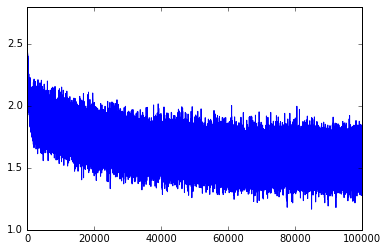

In [56]:
# h = 64, learning-rate =0.1, minibatch_size = 128
# Visualize the learning curve
import matplotlib.pyplot as mplot

mplot.plot(train_loss)
mplot.show()

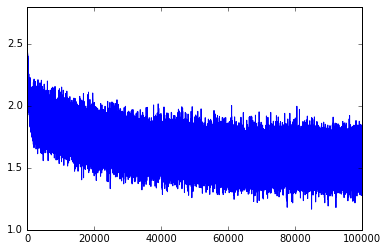

In [55]:
# h = 64, learning-rate =0.1, minibatch_size = 128
# Visualize the learning curve
import matplotlib.pyplot as mplot

mplot.plot(train_loss)
mplot.show()

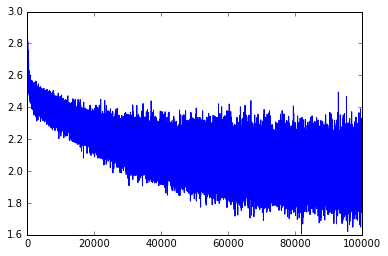

In [53]:
# h = 64, learning-rate =0.001, minibatch_size = 64
# Visualize the learning curve
import matplotlib.pyplot as mplot

mplot.plot(train_loss)
mplot.show()

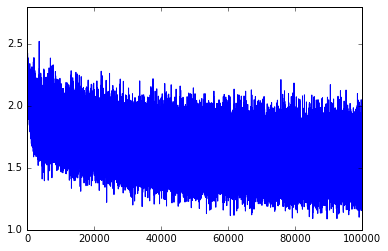

In [51]:
# h = 64, learning-rate =1, minibatch_size = 64
# Visualize the learning curve
import matplotlib.pyplot as mplot

mplot.plot(train_loss)
mplot.show()

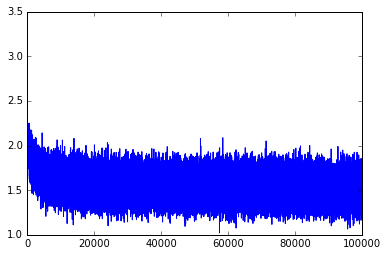

In [48]:
# h = 64, learning-rate =1
# Visualize the learning curve
import matplotlib.pyplot as mplot

mplot.plot(train_loss)
mplot.show()

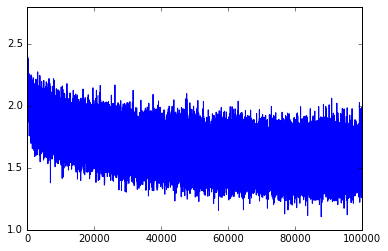

In [46]:
# h = 64, learning-rate = 0.1
# Visualize the learning curve
import matplotlib.pyplot as mplot

mplot.plot(train_loss)
mplot.show()

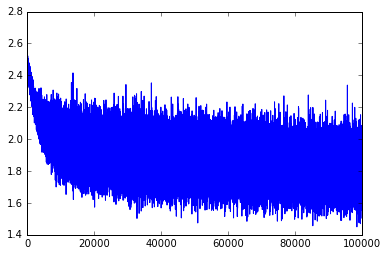

In [44]:
# h = 64, lr = 0.01
# Visualize the learning curve
import matplotlib.pyplot as mplot

mplot.plot(train_loss)
mplot.show()

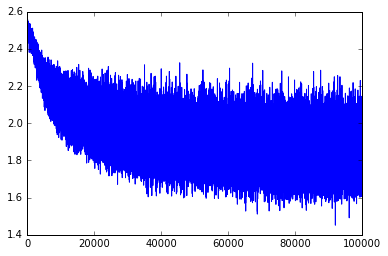

In [29]:
# With biases with hidden layer 10
# Visualize the learning curve
import matplotlib.pyplot as mplot

mplot.plot(train_loss)
mplot.show()

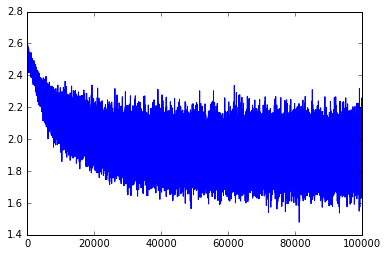

In [219]:
#  No biases
# Visualize the learning curve
import matplotlib.pyplot as mplot

mplot.plot(train_loss)
mplot.show()